This script solves PyMOC and the two-layer model and visualize the results

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# header
'''
This script shows an example of a "two column" model for the 
overturning circulation in a basin connected to a channel in the south.
The first column represents the basin, while the second column represents
the northern sinking region. The overtunning circulation is computed at
the northern end of the basin (at the interface to the northern sinking region)
and at the southern end of the basin (at the interface to the channel).
The parameters chosen here follow more or less the "control" experiment of Nikurashin
and Vallis (2012, JPO).

Update: 1/5/2021, by Hailu Kong - using the BCs from the shoebox setup.

Specifically, 2 changes: SO buoyancy profile (now a linear function of y), 
and diapycnal diffusivity (changed from 2e-5 to 5e-5)

Also record the timeseries of SOMOC, AMOC, ACC, & pycnocline depth D (defined as in G99)
for time series analysis

Update: 1/19/2021, by Hailu Kong: 
KGM is now k0*(D/D0)^{n-1}, where D is pycnocline depth
as diagnosed in the basin, D0 = 794 is a reference depth, and n is a specified power. 

Update: 1/20/2021, by Hailu Kong: 
wind stress now takes a sinusoidal shape, as tested before, to yield a more realistic
Ekman-driven (and therefore, residual) SOMOC: such that its max positive value occurs
somewhere deeper in the upper ocean, instead of the 1st non-surface grid. 

Update: 2/10/2021, by Hailu Kong:
1. Diagnose & save the AMOC & SOMOC timeseries in isopycnal coordinate. 
    Use Psib to map the AMOC
    Manually map(interpolate) the SOMOC, onto the same buoyancy classes 
    as the AMOC: nb=500. Map only when the MOC is updated.

2. The z-coordinate AMOC & SOMOC timeseries remained saved

3. Interpolate the timeseries of basin buoyancy profile b(z) to z(b)
    Update only when the MOC is updated, to save time

Update: 2/14/2021, by Hailu Kong
Found the optimal parameters to reproduce shoebox results:
bs=0.019, n=8; all else remains the same: D0=794, K0=2000

Update: 3/2/2021, by Hailu Kong
Parameterize the stationary eddies as a stretching factor for transient eddies
i.e. K = K0*(D/D0)^{n-1} * (1+K1*(tau/tau0)),
where K0 = 600, following the value from the KGM=Kst+Ktr formulation,
and fit K1 to diagnosed KGM from bsp019_n2, which yields the closest
pycnocline depth.

Update: 3/11/2021, by Hailu Kong
Write out the outline for the paper. 

Update: 6/3/2021, by Hailu Kong
Use the new reference D, diagnosed based on shoebox 40S - 40N averaged D

Update: 6/28/2021, Hailu Kong
Run 2 PyMOC setups in one script: n=2 & n=8, so as to choose the proper value
for $D_0$ that is to be used in its SO parameterization. 

Update: 7/19/2021, Hailu Kong
Tune diapycnal diffusivity to yield the same:
(1) basin upwelling; 
(2) pycnocline depth adjustment timescale
as the GCM

'''
from pymoc.modules import Psi_Thermwind, Psi_SO_Keff, Column
from pymoc.plotting import Interpolate_channel
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit 
import copy
import h5py
import scipy.io as sio


# $n$ = 3

## $\tau_0$ = 0.2 Pa

In [3]:
### ------------ Boundary conditions ---------------- ##
########################################################
# domain geometry
A_basin = 6e13    #area of the basin; shoebox: 6.41e13
A_north = A_basin / 50.    #area of northern sinking region

# meridinoal extent of the Southern Ocean
l = 2.e6  # corresponding to 18 degrees in latitude
# l = 4.e6  # corresponding to 36 deg (shoebox: 35 deg)
y = np.asarray(np.linspace(0, l, 21))
# originally: 40 grids
# Lx = 4.e6 # ACC length from the shoebox/G99

# vertical grid
z = np.asarray(np.linspace(-4000, 0, 31)) 
# just use 30 layers, to speed up integration (also to be consistent with shoebox)
# originally: 80 layers

# S.O. surface boundary conditions
# ----------- buoyancy boundary conditions ------------ #
# bs = 0.03 # at the northern end of Southern Ocean
# shoebox: ~ 0.032 (but across 35 deg, not 18 deg here)
bs = 0.018 # corresponding to the surface density contrast over 18 deg in shoebox
# goal: testing with this smaller bs to see if the solution is closer to shoebox
bs_north = 0.004 # at the northern convection region; 
# shoebox: ~0.003 at the northernmost grid; ~0.005 at the 1st convection grid, about 62 N
bmin = 0.0 # domain minimal buoyancy, = buoyancy at the southern boundary of the domain
nb = 501 # the number of buoyancy classes for interpolating psi onto buoyancy coordinate
bcoord = np.linspace(bmin, bs, nb) # buoyancy coordinate grids

# ---------- surface buoyancy profile ------------ #
# from what I can infer, NV12 use an approximately quadratic surface temperature
# profile in the channel for their SAMBUCA simulations:
# bs_SO = (bs-bmin) * (y / y[-1])**2 + bmin

# shoebox: linear profile for surface buoyancy across the SO
bs_SO = (bs-bmin) * (y/y[-1]) + bmin

# -------------------- wind stress ----------------- #
# # shoebox setup
# tau0 = 0.2/1.57 # corresponding to averaged sinusoidal wind stress over pi
tau0 = 0.2
tau = tau0 * np.sin(y/y[-1]*np.pi)
# tau = tau0
# a sinusoidal form moves the peak of wind-driven MOC from the 1st sub-surface 
# grid to deeper in the interior; in this case about 500m deep

# -------------------- diapycnal diffusivity ----------------- #
# kappa = 2e-5
# # shoebox:
kappa = 5.e-5

# KGM:
K0 = 710.
n = 3 # power to scale 
D0 = 788. # reference depth scale used to scale KGM
K1 = .9 # slope of Kst on wind


# time-stepping parameters:
dt = 86400 * 30    # time-step for vert. adv. diff. calc.
MOC_up_iters = int(
    np.floor(1 * 360 * 86400 / dt)
)    # multiplier for MOC time-step (MOC is updated every MOC_up_iters time steps)
# plot_iters = int(
#     np.ceil(300 * 360 * 86400 / dt)
# )    # plotting frequency (in iterations)
total_iters = int(
    np.ceil(3000 * 360 * 86400 / dt)
)    # total number of timesteps


# Initial conditions for buoyancy profile in the basin
def b_basin(z):
  return bs * np.exp(z / 300.)
def b_north(z):
  return bs_north * np.exp(z / 300.)

Text(0.5, 1.0, 'reference state w/ variable $\\kappa_{GM}$, $K_0$ = 710.0 $m^2/s$')

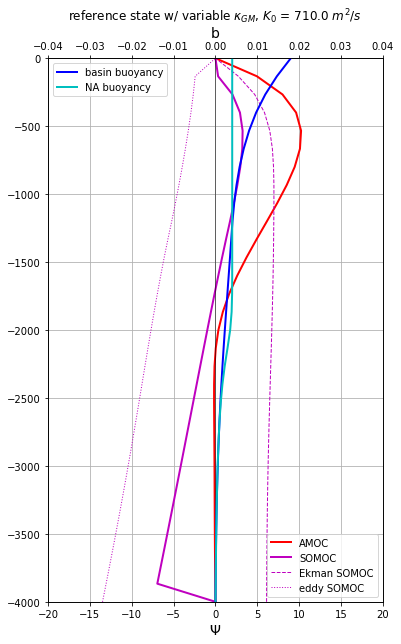

In [4]:
### Create instances of basin, north, SOMOC, and AMOC classes; 
# initialize the variables that record the timeseries of the above 4 quantities;
# Integrate to achieve and visualize solutions

# create N.A. overturning model instance
AMOC = Psi_Thermwind(z=z, b1=b_basin, b2=b_north, f=1e-4)
# and solve for initial overturning streamfunction:
AMOC.solve()
AMOCtp2zt = AMOC.Psi  # store the initial field for AMOC in z-coord
AMOCtp2bt = AMOC.Psib() # initial AMOC in b-coord

# evaluate overturning in isopycnal space:
[Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

# create S.O. overturning model instance
SO = Psi_SO_Keff(
    z=z,
    y=y,
    b=b_basin(z),
    bs=bs_SO,
    tau=tau,
    f=1e-4,
    L=5e6,
    K0=K0, # reference, transient KGM
    n=n, # power in KGM = K0 * (D/D0)^{n-1}
    D0=D0, # reference pycnocline depth
    K1=K1, # 
)
SO.solve()
SOtp2zt = SO.Psi.copy() # store the initial field for SOMOC, in z-coord
SOEktp2zt = SO.Psi_Ek.copy()
zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
SOtp2bt = np.interp(zb, z, SO.Psi) # interpolate to buoyancy coordinate

# create adv-diff column model instance for basin
basin = Column(z=z, kappa=kappa, Area=A_basin, b=b_basin(z), bs=bs, bbot=bmin)
# create adv-diff column model instance for basin
north = Column(z=z, kappa=kappa, Area=A_north, b=b_north(z), bs=bs_north, bbot=bmin)

b_basintp2t = b_basin(z)
b_northtp2t = b_north(z)

# isopycnal interface height timeseries
zb_basintp2t = np.interp(bcoord, basin.b, z)
zb_northtp2t = np.interp(bcoord, north.b, z)

Dtp2t = np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
    / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])


# Main time-stepping loop
for ii in range(1, total_iters+1):
  # update buoyancy profile
  # using z-coordinate overturning:
  #wAb=(AMOC.Psi-SO.Psi)*1e6
  #wAN=-AMOC.Psi*1e6
  # using isopycnal overturning:
  wAb = (Psi_iso_b - SO.Psi) * 1e6
  wAN = -Psi_iso_n * 1e6  # negativity to ensure it's sinking in the N.A.
  basin.timestep(wA=wAb, dt=dt)
  north.timestep(wA=wAN, dt=dt, do_conv=True)
  if ii % MOC_up_iters == 0:
    # update overturning streamfunction (can be done less frequently)

    # buoyancy profiles in the basin & north
    b_basintp2t = np.concatenate((b_basintp2t, basin.b))
    b_northtp2t = np.concatenate((b_northtp2t, north.b))
    # isopycnal interface height in basin & north
    zb_basintp2t = np.concatenate((zb_basintp2t, np.interp(bcoord, basin.b, z)))
    zb_northtp2t = np.concatenate((zb_northtp2t, np.interp(bcoord, north.b, z)))
    # pycnocline depth
    Dtp2t = np.concatenate((Dtp2t, \
                          np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
                         / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])))
    # MOC update
    AMOC.update(b1=basin.b, b2=north.b)
    AMOC.solve()
    AMOCtp2zt = np.concatenate((AMOCtp2zt, AMOC.Psi)) # append AMOC from each update
    AMOCtp2bt = np.concatenate((AMOCtp2bt, AMOC.Psib()))
    [Psi_iso_b, Psi_iso_n] = AMOC.Psibz()
    
    SO.update(b=basin.b)
    SO.solve()
    SOtp2zt = np.concatenate((SOtp2zt, SO.Psi)) # append SOMOC from each update
    SOEktp2zt = np.concatenate((SOEktp2zt, SO.Psi_Ek))
    zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
    SOtp2bt = np.concatenate((SOtp2bt, np.interp(zb, z, SO.Psi))) # interpolate to buoyancy coordinate
    
    
# reshape recorded MOC & buoyancy profile & interface heights 
# such that each row is from one timestamp and each column is from one layer
AMOCtp2zt = AMOCtp2zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
AMOCtp2bt = AMOCtp2bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

SOtp2zt = SOtp2zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOEktp2zt = SOEktp2zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOtp2bt = SOtp2bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

b_basintp2t = b_basintp2t.reshape((int(total_iters/MOC_up_iters)+1, 31))
b_northtp2t = b_northtp2t.reshape((int(total_iters/MOC_up_iters)+1, 31))

zb_basintp2t = zb_basintp2t.reshape((int(total_iters/MOC_up_iters)+1, nb))
zb_northtp2t = zb_northtp2t.reshape((int(total_iters/MOC_up_iters)+1, nb))

AMOCtp2z = AMOCtp2zt[-1, :].copy()
AMOCtp2b = AMOCtp2bt[-1, :].copy()
SOtp2z = SOtp2zt[-1, :].copy()
SOtp2b = SOtp2bt[-1, :].copy()
b_basintp2 = b_basintp2t[-1, :].copy()
b_northtp2 = b_northtp2t[-1, :].copy()
zb_basintp2 = zb_basintp2t[-1, :].copy()
zb_northtp2 = zb_northtp2t[-1, :].copy()

np.savez('result/Solving_PyMOC_tp2', AMOCtp2zt=AMOCtp2zt, \
         AMOCtp2bt=AMOCtp2bt, SOtp2zt=SOtp2zt, SOtp2bt=SOtp2bt, \
         SOEktp2zt=SOEktp2zt, b_basintp2t=b_basintp2t, b_northtp2t=b_northtp2t, \
         zb_basintp2t=zb_basintp2t, zb_northtp2t=zb_northtp2t, Dtp2t=Dtp2t, \
         SO_Ektp2z = SO.Psi_Ek.copy(), SO_GMtp2z = SO.Psi_GM.copy())

# Plot equilibrated vertical profiles of buoyancy & MOC
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.ylim((-4e3, 0))
ax1.set_xlim((-20, 20))  # MOC
ax2.set_xlim((-0.04, 0.04))  # buoyancy
ax1.set_xlabel('$\Psi$', fontsize=14)
ax2.set_xlabel('b', fontsize=14)

# ax1.plot(AMOC.Psi, AMOC.z, linewidth=0.5, color='r', label='AMOC')
# ax1.plot(SO.Psi, SO.z, linewidth=0.5, color='m', label='SOMOC')
# ax2.plot(basin.b, basin.z, linewidth=0.5, color='b', label='basin buoyancy')
# ax2.plot(north.b, north.z, linewidth=0.5, color='c', label='basin buoyancy')
# # plt.legend()

# Plot final results over time-iteration plot:
ax1.plot(AMOC.Psi, AMOC.z, linewidth=2, color='r', label='AMOC')
ax1.plot(SO.Psi, SO.z, linewidth=2, color='m', label='SOMOC')
ax1.plot(SO.Psi_Ek, SO.z, linewidth=1, color='m', linestyle='--', label='Ekman SOMOC')
ax1.plot(SO.Psi_GM, SO.z, linewidth=1, color='m', linestyle=':', label='eddy SOMOC')
ax2.plot(basin.b, basin.z, linewidth=2, color='b', label='basin buoyancy')
ax2.plot(north.b, basin.z, linewidth=2, color='c', label='NA buoyancy')
ax1.plot(0. * AMOC.z, AMOC.z, linewidth=0.5, color='k')
ax1.grid()

ax1.legend(loc=4)
ax2.legend(loc=2)

plt.title(r'reference state w/ variable $\kappa_{GM}$, $K_0$ = ' + str(K0) + ' $m^2/s$')

# plt.savefig('pics/profile_Kst_Ktr_bsp018_625_1p15_tp2.pdf')
# plt.show()


## 50% wind increase

Text(0.5, 1.0, 'reference state w/ variable $\\kappa_{GM}$, $K_0$ = 710.0 $m^2/s$')

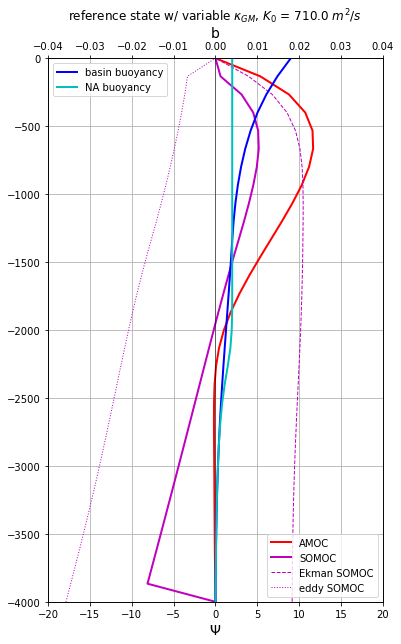

In [5]:
# Re-do the above calculations but use a new wind stress: tau_0 = 0.3 Pa
tau = 1.5 * tau0 * np.sin(y/y[-1]*np.pi)

# re-create N.A. overturning model instance
AMOC = Psi_Thermwind(z=z, b1=b_basintp2, b2=b_northtp2, f=1e-4)
# and solve for initial overturning streamfunction:
AMOC.solve()
AMOCtp3zt = AMOC.Psi
AMOCtp3bt = AMOC.Psib()
# evaluate overturning in isopycnal space:
[Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

# create S.O. overturning model instance
SO = Psi_SO_Keff(
    z=z,
    y=y,
    b=b_basintp2,
    bs=bs_SO,
    tau=tau,
    f=1e-4,
    L=5e6,
    K0=K0,
    n=n,
    D0=D0,
    K1=K1
)
SO.solve()
SOtp3zt = SO.Psi.copy()
SOEktp3zt = SO.Psi_Ek.copy()
zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
SOtp3bt = np.interp(zb, z, SO.Psi) # interpolate to buoyancy coordinate

# a step change in SO is expected: since wind has increased by 50% but isopycnal doesn't have time to respond yet

# create adv-diff column model instance for basin
basin = Column(z=z, kappa=kappa, Area=A_basin, b=b_basintp2.copy(), bs=bs, bbot=bmin)
# create adv-diff column model instance for northern region
north = Column(z=z, kappa=kappa, Area=A_north, b=b_northtp2.copy(), bs=bs_north, bbot=bmin)

b_basintp3t = b_basintp2.copy()
b_northtp3t = b_northtp2.copy()
# isopycnal interface height timeseries
zb_basintp3t = np.interp(bcoord, basin.b, z)
zb_northtp3t = np.interp(bcoord, north.b, z)

Dtp3t = np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
    / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])


#################################################################################
### -------------------- Main time-stepping loop -----------------------------###
#################################################################################
for ii in range(1, total_iters+1):
  # update buoyancy profile
  # using z-coordinate overturning:
  #wAb=(AMOC.Psi-SO.Psi)*1e6
  #wAN=-AMOC.Psi*1e6
  # using isopycnal overturning:
  wAb = (Psi_iso_b - SO.Psi) * 1e6
  wAN = -Psi_iso_n * 1e6  # negativity to ensure it's sinking in the N.A.
  basin.timestep(wA=wAb, dt=dt)
  north.timestep(wA=wAN, dt=dt, do_conv=True)
  if ii % MOC_up_iters == 0:
    # record buoyancy profiles in basin & north
    b_basintp3t = np.concatenate((b_basintp3t, basin.b))
    b_northtp3t = np.concatenate((b_northtp3t, north.b))
    
    zb_basintp3t = np.concatenate((zb_basintp3t, np.interp(bcoord, basin.b, z)))
    zb_northtp3t = np.concatenate((zb_northtp3t, np.interp(bcoord, north.b, z)))
    
    Dtp3t = np.concatenate((Dtp3t, \
                          np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
                         / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])))
    
    # update overturning streamfunction (can be done less frequently)
    AMOC.update(b1=basin.b, b2=north.b)
    AMOC.solve()
    AMOCtp3zt = np.concatenate((AMOCtp3zt, AMOC.Psi)) # append AMOC from each update
    AMOCtp3bt = np.concatenate((AMOCtp3bt, AMOC.Psib()))
    [Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

    SO.update(b=basin.b)
    SO.solve()
    SOtp3zt = np.concatenate((SOtp3zt, SO.Psi)) # append SOMOC from each update
    SOEktp3zt = np.concatenate((SOEktp3zt, SO.Psi_Ek))
    zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
    SOtp3bt = np.concatenate((SOtp3bt, np.interp(zb, z, SO.Psi))) # interpolate to buoyancy coordinate
    
#################################################################################
### -------------------- Re-shape MOC & b timeseries -------------------------###
# such that each row is from one timestamp and each column is from one layer
#################################################################################

AMOCtp3zt = AMOCtp3zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
AMOCtp3bt = AMOCtp3bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

SOtp3zt = SOtp3zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOEktp3zt = SOEktp3zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOtp3bt = SOtp3bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

b_basintp3t = b_basintp3t.reshape((int(total_iters/MOC_up_iters)+1, 31))
b_northtp3t = b_northtp3t.reshape((int(total_iters/MOC_up_iters)+1, 31))

zb_basintp3t = zb_basintp3t.reshape((int(total_iters/MOC_up_iters)+1, nb))
zb_northtp3t = zb_northtp3t.reshape((int(total_iters/MOC_up_iters)+1, nb))

AMOC1z = AMOCtp3zt[-1, :].copy()
AMOC1b = AMOCtp3bt[-1, :].copy()
SOtp3z = SOtp3zt[-1, :].copy()
SOtp3b = SOtp3bt[-1, :].copy()
b_basintp3 = b_basintp3t[-1, :].copy()
b_northtp3 = b_northtp3t[-1, :].copy()
zb_basintp3 = zb_basintp3t[-1, :].copy()
zb_northtp3 = zb_northtp3t[-1, :].copy()

np.savez('result/Solving_PyMOC_tp3', AMOCtp3zt=AMOCtp3zt, \
         AMOCtp3bt=AMOCtp3bt, SOtp3zt=SOtp3zt, SOtp3bt=SOtp3bt, \
         SOEktp3zt=SOEktp3zt, b_basintp3t=b_basintp3t, b_northtp3t=b_northtp3t, \
         zb_basintp3t=zb_basintp3t, zb_northtp3t=zb_northtp3t, Dtp3t=Dtp3t, \
         SO_Ektp3z = SO.Psi_Ek.copy(), SO_GMtp3z = SO.Psi_GM.copy())

# Plot equilibrated vertical profiles of buoyancy & MOC
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.ylim((-4e3, 0))
ax1.set_xlim((-20, 20))  # MOC
ax2.set_xlim((-0.04, 0.04))  # buoyancy
ax1.set_xlabel('$\Psi$', fontsize=14)
ax2.set_xlabel('b', fontsize=14)

# ax1.plot(AMOC.Psi, AMOC.z, linewidth=0.5, color='r', label='AMOC')
# ax1.plot(SO.Psi, SO.z, linewidth=0.5, color='m', label='SOMOC')
# ax2.plot(basin.b, basin.z, linewidth=0.5, color='b', label='basin buoyancy')
# ax2.plot(north.b, north.z, linewidth=0.5, color='c', label='basin buoyancy')
# # plt.legend()

# Plot final results over time-iteration plot:
ax1.plot(AMOC.Psi, AMOC.z, linewidth=2, color='r', label='AMOC')
ax1.plot(SO.Psi, SO.z, linewidth=2, color='m', label='SOMOC')
ax1.plot(SO.Psi_Ek, SO.z, linewidth=1, color='m', linestyle='--', label='Ekman SOMOC')
ax1.plot(SO.Psi_GM, SO.z, linewidth=1, color='m', linestyle=':', label='eddy SOMOC')
ax2.plot(basin.b, basin.z, linewidth=2, color='b', label='basin buoyancy')
ax2.plot(north.b, basin.z, linewidth=2, color='c', label='NA buoyancy')
ax1.plot(0. * AMOC.z, AMOC.z, linewidth=0.5, color='k')
ax1.grid()

ax1.legend(loc=4)
ax2.legend(loc=2)

plt.title(r'reference state w/ variable $\kappa_{GM}$, $K_0$ = ' + str(K0) + ' $m^2/s$')

# plt.savefig('pics/profile_Kst_Ktr_bsp018_625_1p15_tp2.pdf')
# plt.show()


## 50% wind decrease

Text(0.5, 1.0, 'tp1')

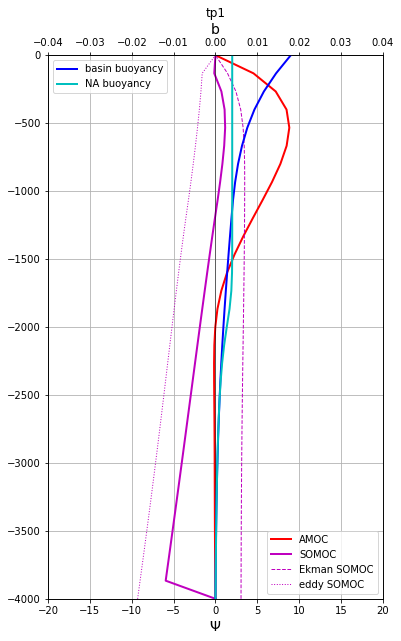

In [6]:
# Re-do the above calculations but use a new wind stress: tau_0 = 0.1 Pa
tau = .5 * tau0 * np.sin(y/y[-1]*np.pi)

# re-create N.A. overturning model instance
AMOC = Psi_Thermwind(z=z, b1=b_basintp2, b2=b_northtp2, f=1e-4)
# and solve for initial overturning streamfunction:
AMOC.solve()
AMOCtp1zt = AMOC.Psi
AMOCtp1bt = AMOC.Psib()
# evaluate overturning in isopycnal space:
[Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

# create S.O. overturning model instance
SO = Psi_SO_Keff(
    z=z,
    y=y,
    b=b_basintp2,
    bs=bs_SO,
    tau=tau,
    f=1e-4,
    L=5e6,
    K0=K0,
    n=n,
    D0=D0,
    K1=K1
)
SO.solve()
SOtp1zt = SO.Psi.copy()
SOEktp1zt = SO.Psi_Ek.copy()
zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
SOtp1bt = np.interp(zb, z, SO.Psi) # interpolate to buoyancy coordinate

# a step change in SO is expected: since wind has increased by 50% but isopycnal doesn't have time to respond yet

# create adv-diff column model instance for basin
basin = Column(z=z, kappa=kappa, Area=A_basin, b=b_basintp2.copy(), bs=bs, bbot=bmin)
# create adv-diff column model instance for northern region
north = Column(z=z, kappa=kappa, Area=A_north, b=b_northtp2.copy(), bs=bs_north, bbot=bmin)

b_basintp1t = b_basintp2.copy()
b_northtp1t = b_northtp2.copy()
# isopycnal interface height timeseries
zb_basintp1t = np.interp(bcoord, basin.b, z)
zb_northtp1t = np.interp(bcoord, north.b, z)

Dtp1t = np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
    / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])


#################################################################################
### -------------------- Main time-stepping loop -----------------------------###
#################################################################################
for ii in range(1, total_iters+1):
  # update buoyancy profile
  # using z-coordinate overturning:
  #wAb=(AMOC.Psi-SO.Psi)*1e6
  #wAN=-AMOC.Psi*1e6
  # using isopycnal overturning:
  wAb = (Psi_iso_b - SO.Psi) * 1e6
  wAN = -Psi_iso_n * 1e6  # negativity to ensure it's sinking in the N.A.
  basin.timestep(wA=wAb, dt=dt)
  north.timestep(wA=wAN, dt=dt, do_conv=True)
  if ii % MOC_up_iters == 0:
    # record buoyancy profiles in basin & north
    b_basintp1t = np.concatenate((b_basintp1t, basin.b))
    b_northtp1t = np.concatenate((b_northtp1t, north.b))
    
    zb_basintp1t = np.concatenate((zb_basintp1t, np.interp(bcoord, basin.b, z)))
    zb_northtp1t = np.concatenate((zb_northtp1t, np.interp(bcoord, north.b, z)))
    
    Dtp1t = np.concatenate((Dtp1t, \
                          np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
                         / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])))
    
    # update overturning streamfunction (can be done less frequently)
    AMOC.update(b1=basin.b, b2=north.b)
    AMOC.solve()
    AMOCtp1zt = np.concatenate((AMOCtp1zt, AMOC.Psi)) # append AMOC from each update
    AMOCtp1bt = np.concatenate((AMOCtp1bt, AMOC.Psib()))
    [Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

    SO.update(b=basin.b)
    SO.solve()
    SOtp1zt = np.concatenate((SOtp1zt, SO.Psi)) # append SOMOC from each update
    SOEktp1zt = np.concatenate((SOEktp1zt, SO.Psi_Ek))
    zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
    SOtp1bt = np.concatenate((SOtp1bt, np.interp(zb, z, SO.Psi))) # interpolate to buoyancy coordinate
    
#################################################################################
### -------------------- Re-shape MOC & b timeseries -------------------------###
# such that each row is from one timestamp and each column is from one layer
#################################################################################

AMOCtp1zt = AMOCtp1zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
AMOCtp1bt = AMOCtp1bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

SOtp1zt = SOtp1zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOEktp1zt = SOEktp1zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOtp1bt = SOtp1bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

b_basintp1t = b_basintp1t.reshape((int(total_iters/MOC_up_iters)+1, 31))
b_northtp1t = b_northtp1t.reshape((int(total_iters/MOC_up_iters)+1, 31))

zb_basintp1t = zb_basintp1t.reshape((int(total_iters/MOC_up_iters)+1, nb))
zb_northtp1t = zb_northtp1t.reshape((int(total_iters/MOC_up_iters)+1, nb))

AMOC1z = AMOCtp1zt[-1, :].copy()
AMOC1b = AMOCtp1bt[-1, :].copy()
SOtp1z = SOtp1zt[-1, :].copy()
SOtp1b = SOtp1bt[-1, :].copy()
b_basintp1 = b_basintp1t[-1, :].copy()
b_northtp1 = b_northtp1t[-1, :].copy()
zb_basintp1 = zb_basintp1t[-1, :].copy()
zb_northtp1 = zb_northtp1t[-1, :].copy()

np.savez('result/Solving_PyMOC_tp1', AMOCtp1zt=AMOCtp1zt, \
         AMOCtp1bt=AMOCtp1bt, SOtp1zt=SOtp1zt, SOtp1bt=SOtp1bt, \
         SOEktp1zt=SOEktp1zt, b_basintp1t=b_basintp1t, b_northtp1t=b_northtp1t, \
         zb_basintp1t=zb_basintp1t, zb_northtp1t=zb_northtp1t, Dtp1t=Dtp1t, \
         SO_Ektp1z = SO.Psi_Ek.copy(), SO_GMtp1z = SO.Psi_GM.copy())

# Plot equilibrated vertical profiles of buoyancy & MOC
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.ylim((-4e3, 0))
ax1.set_xlim((-20, 20))  # MOC
ax2.set_xlim((-0.04, 0.04))  # buoyancy
ax1.set_xlabel('$\Psi$', fontsize=14)
ax2.set_xlabel('b', fontsize=14)

# ax1.plot(AMOC.Psi, AMOC.z, linewidth=0.5, color='r', label='AMOC')
# ax1.plot(SO.Psi, SO.z, linewidth=0.5, color='m', label='SOMOC')
# ax2.plot(basin.b, basin.z, linewidth=0.5, color='b', label='basin buoyancy')
# ax2.plot(north.b, north.z, linewidth=0.5, color='c', label='basin buoyancy')
# # plt.legend()

# Plot final results over time-iteration plot:
ax1.plot(AMOC.Psi, AMOC.z, linewidth=2, color='r', label='AMOC')
ax1.plot(SO.Psi, SO.z, linewidth=2, color='m', label='SOMOC')
ax1.plot(SO.Psi_Ek, SO.z, linewidth=1, color='m', linestyle='--', label='Ekman SOMOC')
ax1.plot(SO.Psi_GM, SO.z, linewidth=1, color='m', linestyle=':', label='eddy SOMOC')
ax2.plot(basin.b, basin.z, linewidth=2, color='b', label='basin buoyancy')
ax2.plot(north.b, basin.z, linewidth=2, color='c', label='NA buoyancy')
ax1.plot(0. * AMOC.z, AMOC.z, linewidth=0.5, color='k')
ax1.grid()

ax1.legend(loc=4)
ax2.legend(loc=2)

plt.title(r'tp1')

# plt.savefig('pics/profile_Kst_Ktr_bsp018_625_1p15_tp2.pdf')
# plt.show()


## 75% wind decrease

Text(0.5, 1.0, 'reference state w/ variable $\\kappa_{GM}$, $K_0$ = 710.0 $m^2/s$')

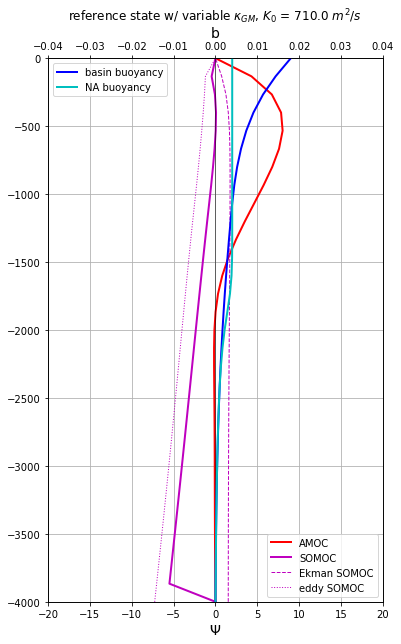

In [7]:
# Re-do the above calculations but use a new wind stress: tau_0 = 0.05 Pa
tau = .25 * tau0 * np.sin(y/y[-1]*np.pi)
# tau = 1.5*tau0

# re-create N.A. overturning model instance
AMOC = Psi_Thermwind(z=z, b1=b_basintp2, b2=b_northtp2, f=1e-4)
# and solve for initial overturning streamfunction:
AMOC.solve()
AMOCtp05zt = AMOC.Psi
AMOCtp05bt = AMOC.Psib()
# evaluate overturning in isopycnal space:
[Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

# create S.O. overturning model instance
SO = Psi_SO_Keff(
    z=z,
    y=y,
    b=b_basintp2,
    bs=bs_SO,
    tau=tau,
    f=1e-4,
    L=5e6,
    K0=K0,
    n=n,
    D0=D0,
    K1=K1
)
SO.solve()
SOtp05zt = SO.Psi.copy()
SOEktp05zt = SO.Psi_Ek.copy()
zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
SOtp05bt = np.interp(zb, z, SO.Psi) # interpolate to buoyancy coordinate

# a step change in SO is expected: since wind has increased by 50% but isopycnal doesn't have time to respond yet

# create adv-diff column model instance for basin
basin = Column(z=z, kappa=kappa, Area=A_basin, b=b_basintp2.copy(), bs=bs, bbot=bmin)
# create adv-diff column model instance for northern region
north = Column(z=z, kappa=kappa, Area=A_north, b=b_northtp2.copy(), bs=bs_north, bbot=bmin)

b_basintp05t = b_basintp2.copy()
b_northtp05t = b_northtp2.copy()
# isopycnal interface height timeseries
zb_basintp05t = np.interp(bcoord, basin.b, z)
zb_northtp05t = np.interp(bcoord, north.b, z)

Dtp05t = np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
    / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])


#################################################################################
### -------------------- Main time-stepping loop -----------------------------###
#################################################################################
for ii in range(1, total_iters+1):
  # update buoyancy profile
  # using z-coordinate overturning:
  #wAb=(AMOC.Psi-SO.Psi)*1e6
  #wAN=-AMOC.Psi*1e6
  # using isopycnal overturning:
  wAb = (Psi_iso_b - SO.Psi) * 1e6
  wAN = -Psi_iso_n * 1e6  # negativity to ensure it's sinking in the N.A.
  basin.timestep(wA=wAb, dt=dt)
  north.timestep(wA=wAN, dt=dt, do_conv=True)
  if ii % MOC_up_iters == 0:
    # record buoyancy profiles in basin & north
    b_basintp05t = np.concatenate((b_basintp05t, basin.b))
    b_northtp05t = np.concatenate((b_northtp05t, north.b))
    
    zb_basintp05t = np.concatenate((zb_basintp05t, np.interp(bcoord, basin.b, z)))
    zb_northtp05t = np.concatenate((zb_northtp05t, np.interp(bcoord, north.b, z)))
    
    Dtp05t = np.concatenate((Dtp05t, \
                          np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
                         / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])))
    
    # update overturning streamfunction (can be done less frequently)
    AMOC.update(b1=basin.b, b2=north.b)
    AMOC.solve()
    AMOCtp05zt = np.concatenate((AMOCtp05zt, AMOC.Psi)) # append AMOC from each update
    AMOCtp05bt = np.concatenate((AMOCtp05bt, AMOC.Psib()))
    [Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

    SO.update(b=basin.b)
    SO.solve()
    SOtp05zt = np.concatenate((SOtp05zt, SO.Psi)) # append SOMOC from each update
    SOEktp05zt = np.concatenate((SOEktp05zt, SO.Psi_Ek))
    zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
    SOtp05bt = np.concatenate((SOtp05bt, np.interp(zb, z, SO.Psi))) # interpolate to buoyancy coordinate
    
#################################################################################
### -------------------- Re-shape MOC & b timeseries -------------------------###
# such that each row is from one timestamp and each column is from one layer
#################################################################################

AMOCtp05zt = AMOCtp05zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
AMOCtp05bt = AMOCtp05bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

SOtp05zt = SOtp05zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOEktp05zt = SOEktp05zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOtp05bt = SOtp05bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

b_basintp05t = b_basintp05t.reshape((int(total_iters/MOC_up_iters)+1, 31))
b_northtp05t = b_northtp05t.reshape((int(total_iters/MOC_up_iters)+1, 31))

zb_basintp05t = zb_basintp05t.reshape((int(total_iters/MOC_up_iters)+1, nb))
zb_northtp05t = zb_northtp05t.reshape((int(total_iters/MOC_up_iters)+1, nb))

AMOC1z = AMOCtp05zt[-1, :].copy()
AMOC1b = AMOCtp05bt[-1, :].copy()
SOtp05z = SOtp05zt[-1, :].copy()
SOtp05b = SOtp05bt[-1, :].copy()
b_basintp05 = b_basintp05t[-1, :].copy()
b_northtp05 = b_northtp05t[-1, :].copy()
zb_basintp05 = zb_basintp05t[-1, :].copy()
zb_northtp05 = zb_northtp05t[-1, :].copy()

np.savez('result/Solving_PyMOC_tp05', AMOCtp05zt=AMOCtp05zt, \
         AMOCtp05bt=AMOCtp05bt, SOtp05zt=SOtp05zt, SOtp05bt=SOtp05bt, \
         SOEktp05zt=SOEktp05zt, b_basintp05t=b_basintp05t, b_northtp05t=b_northtp05t, \
         zb_basintp05t=zb_basintp05t, zb_northtp05t=zb_northtp05t, Dtp05t=Dtp05t, \
         SO_Ektp05z = SO.Psi_Ek.copy(), SO_GMtp05z = SO.Psi_GM.copy())

# Plot equilibrated vertical profiles of buoyancy & MOC
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.ylim((-4e3, 0))
ax1.set_xlim((-20, 20))  # MOC
ax2.set_xlim((-0.04, 0.04))  # buoyancy
ax1.set_xlabel('$\Psi$', fontsize=14)
ax2.set_xlabel('b', fontsize=14)

# ax1.plot(AMOC.Psi, AMOC.z, linewidth=0.5, color='r', label='AMOC')
# ax1.plot(SO.Psi, SO.z, linewidth=0.5, color='m', label='SOMOC')
# ax2.plot(basin.b, basin.z, linewidth=0.5, color='b', label='basin buoyancy')
# ax2.plot(north.b, north.z, linewidth=0.5, color='c', label='basin buoyancy')
# # plt.legend()

# Plot final results over time-iteration plot:
ax1.plot(AMOC.Psi, AMOC.z, linewidth=2, color='r', label='AMOC')
ax1.plot(SO.Psi, SO.z, linewidth=2, color='m', label='SOMOC')
ax1.plot(SO.Psi_Ek, SO.z, linewidth=1, color='m', linestyle='--', label='Ekman SOMOC')
ax1.plot(SO.Psi_GM, SO.z, linewidth=1, color='m', linestyle=':', label='eddy SOMOC')
ax2.plot(basin.b, basin.z, linewidth=2, color='b', label='basin buoyancy')
ax2.plot(north.b, basin.z, linewidth=2, color='c', label='NA buoyancy')
ax1.plot(0. * AMOC.z, AMOC.z, linewidth=0.5, color='k')
ax1.grid()

ax1.legend(loc=4)
ax2.legend(loc=2)

plt.title(r'reference state w/ variable $\kappa_{GM}$, $K_0$ = ' + str(K0) + ' $m^2/s$')

# plt.savefig('pics/profile_Kst_Ktr_bsp018_625_1p15_tp2.pdf')
# plt.show()


## 0 wind stress

Text(0.5, 1.0, 'reference state w/ variable $\\kappa_{GM}$, $K_0$ = 710.0 $m^2/s$')

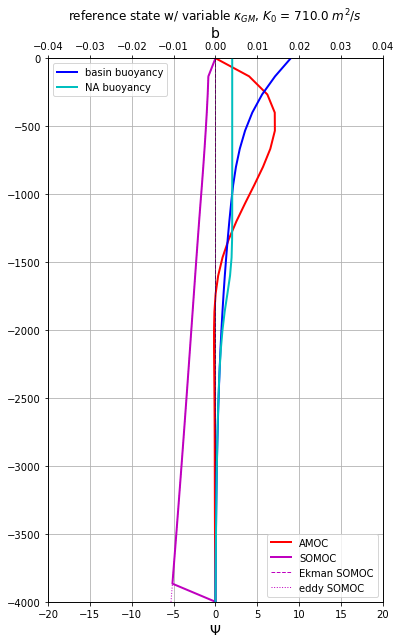

In [8]:
# Re-do the above calculations but use a new wind stress: tau_0 = 0 Pa
tau = 0.0

# re-create N.A. overturning model instance
AMOC = Psi_Thermwind(z=z, b1=b_basintp2, b2=b_northtp2, f=1e-4)
# and solve for initial overturning streamfunction:
AMOC.solve()
AMOCtp0zt = AMOC.Psi
AMOCtp0bt = AMOC.Psib()
# evaluate overturning in isopycnal space:
[Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

# create S.O. overturning model instance
SO = Psi_SO_Keff(
    z=z,
    y=y,
    b=b_basintp2,
    bs=bs_SO,
    tau=tau,
    f=1e-4,
    L=5e6,
    K0=K0,
    n=n,
    D0=D0,
    K1=K1
)
SO.solve()
SOtp0zt = SO.Psi.copy()
SOEktp0zt = SO.Psi_Ek.copy()
zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
SOtp0bt = np.interp(zb, z, SO.Psi) # interpolate to buoyancy coordinate

# a step change in SO is expected: since wind has increased by 50% but isopycnal doesn't have time to respond yet

# create adv-diff column model instance for basin
basin = Column(z=z, kappa=kappa, Area=A_basin, b=b_basintp2.copy(), bs=bs, bbot=bmin)
# create adv-diff column model instance for northern region
north = Column(z=z, kappa=kappa, Area=A_north, b=b_northtp2.copy(), bs=bs_north, bbot=bmin)

b_basintp0t = b_basintp2.copy()
b_northtp0t = b_northtp2.copy()
# isopycnal interface height timeseries
zb_basintp0t = np.interp(bcoord, basin.b, z)
zb_northtp0t = np.interp(bcoord, north.b, z)

Dtp0t = np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
    / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])


#################################################################################
### -------------------- Main time-stepping loop -----------------------------###
#################################################################################
for ii in range(1, total_iters+1):
  # update buoyancy profile
  # using z-coordinate overturning:
  #wAb=(AMOC.Psi-SO.Psi)*1e6
  #wAN=-AMOC.Psi*1e6
  # using isopycnal overturning:
  wAb = (Psi_iso_b - SO.Psi) * 1e6
  wAN = -Psi_iso_n * 1e6  # negativity to ensure it's sinking in the N.A.
  basin.timestep(wA=wAb, dt=dt)
  north.timestep(wA=wAN, dt=dt, do_conv=True)
  if ii % MOC_up_iters == 0:
    # record buoyancy profiles in basin & north
    b_basintp0t = np.concatenate((b_basintp0t, basin.b))
    b_northtp0t = np.concatenate((b_northtp0t, north.b))
    
    zb_basintp0t = np.concatenate((zb_basintp0t, np.interp(bcoord, basin.b, z)))
    zb_northtp0t = np.concatenate((zb_northtp0t, np.interp(bcoord, north.b, z)))
    
    Dtp0t = np.concatenate((Dtp0t, \
                          np.array([-np.sum((basin.b[1:]-basin.b[0]) * z[1:] * (z[1:]-z[:-1])) \
                         / np.sum((basin.b[1:]-basin.b[0]) * (z[1:]-z[:-1]))])))
    
    # update overturning streamfunction (can be done less frequently)
    AMOC.update(b1=basin.b, b2=north.b)
    AMOC.solve()
    AMOCtp0zt = np.concatenate((AMOCtp0zt, AMOC.Psi)) # append AMOC from each update
    AMOCtp0bt = np.concatenate((AMOCtp0bt, AMOC.Psib()))
    [Psi_iso_b, Psi_iso_n] = AMOC.Psibz()

    SO.update(b=basin.b)
    SO.solve()
    SOtp0zt = np.concatenate((SOtp0zt, SO.Psi)) # append SOMOC from each update
    SOEktp0zt = np.concatenate((SOEktp0zt, SO.Psi_Ek))
    zb = np.interp(bcoord, SO.b(z), SO.z) # z coordinate for the fixed bcoord grids
    SOtp0bt = np.concatenate((SOtp0bt, np.interp(zb, z, SO.Psi))) # interpolate to buoyancy coordinate
    
#################################################################################
### -------------------- Re-shape MOC & b timeseries -------------------------###
# such that each row is from one timestamp and each column is from one layer
#################################################################################

AMOCtp0zt = AMOCtp0zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
AMOCtp0bt = AMOCtp0bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

SOtp0zt = SOtp0zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOEktp0zt = SOEktp0zt.reshape((int(total_iters/MOC_up_iters)+1, 31))
SOtp0bt = SOtp0bt.reshape((int(total_iters/MOC_up_iters)+1, nb))

b_basintp0t = b_basintp0t.reshape((int(total_iters/MOC_up_iters)+1, 31))
b_northtp0t = b_northtp0t.reshape((int(total_iters/MOC_up_iters)+1, 31))

zb_basintp0t = zb_basintp0t.reshape((int(total_iters/MOC_up_iters)+1, nb))
zb_northtp0t = zb_northtp0t.reshape((int(total_iters/MOC_up_iters)+1, nb))

AMOC1z = AMOCtp0zt[-1, :].copy()
AMOC1b = AMOCtp0bt[-1, :].copy()
SOtp0z = SOtp0zt[-1, :].copy()
SOtp0b = SOtp0bt[-1, :].copy()
b_basintp0 = b_basintp0t[-1, :].copy()
b_northtp0 = b_northtp0t[-1, :].copy()
zb_basintp0 = zb_basintp0t[-1, :].copy()
zb_northtp0 = zb_northtp0t[-1, :].copy()

np.savez('result/Solving_PyMOC_tp0', AMOCtp0zt=AMOCtp0zt, \
         AMOCtp0bt=AMOCtp0bt, SOtp0zt=SOtp0zt, SOtp0bt=SOtp0bt, \
         SOEktp0zt=SOEktp0zt, b_basintp0t=b_basintp0t, b_northtp0t=b_northtp0t, \
         zb_basintp0t=zb_basintp0t, zb_northtp0t=zb_northtp0t, Dtp0t=Dtp0t, \
         SO_Ektp0z = SO.Psi_Ek.copy(), SO_GMtp0z = SO.Psi_GM.copy())

# Plot equilibrated vertical profiles of buoyancy & MOC
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.ylim((-4e3, 0))
ax1.set_xlim((-20, 20))  # MOC
ax2.set_xlim((-0.04, 0.04))  # buoyancy
ax1.set_xlabel('$\Psi$', fontsize=14)
ax2.set_xlabel('b', fontsize=14)

# ax1.plot(AMOC.Psi, AMOC.z, linewidth=0.5, color='r', label='AMOC')
# ax1.plot(SO.Psi, SO.z, linewidth=0.5, color='m', label='SOMOC')
# ax2.plot(basin.b, basin.z, linewidth=0.5, color='b', label='basin buoyancy')
# ax2.plot(north.b, north.z, linewidth=0.5, color='c', label='basin buoyancy')
# # plt.legend()

# Plot final results over time-iteration plot:
ax1.plot(AMOC.Psi, AMOC.z, linewidth=2, color='r', label='AMOC')
ax1.plot(SO.Psi, SO.z, linewidth=2, color='m', label='SOMOC')
ax1.plot(SO.Psi_Ek, SO.z, linewidth=1, color='m', linestyle='--', label='Ekman SOMOC')
ax1.plot(SO.Psi_GM, SO.z, linewidth=1, color='m', linestyle=':', label='eddy SOMOC')
ax2.plot(basin.b, basin.z, linewidth=2, color='b', label='basin buoyancy')
ax2.plot(north.b, basin.z, linewidth=2, color='c', label='NA buoyancy')
ax1.plot(0. * AMOC.z, AMOC.z, linewidth=0.5, color='k')
ax1.grid()

ax1.legend(loc=4)
ax2.legend(loc=2)

plt.title(r'reference state w/ variable $\kappa_{GM}$, $K_0$ = ' + str(K0) + ' $m^2/s$')

# plt.savefig('pics/profile_Kst_Ktr_bsp018_625_1p15_tp2.pdf')
# plt.show()


# Equilibrium solution

## Re-load saved data for $n$ = 3 & $n$ = 8

In [16]:
# n = 3
tp0n3 = np.load('result/Solving_PyMOC_tp0.npz')
Dtp0n3t = tp0n3['Dtp0t']; 
AMOCtp0n3zt = tp0n3['AMOCtp0zt']
AMOCtp0n3bt = tp0n3['AMOCtp0bt']
SOtp0n3z = tp0n3['SOtp0zt'][-1, :].copy()
SOtp0n3zt = tp0n3['SOtp0zt'].copy()
SOtp0n3bt = tp0n3['SOtp0bt']
b_basintp0n3 = tp0n3['b_basintp0t'][-1, :].copy()
b_basintp0n3t = tp0n3['b_basintp0t'].copy()
b_northtp0n3t = tp0n3['b_northtp0t'].copy()
zb_basintp0n3 = tp0n3['zb_basintp0t'][-1, :].copy()
zb_basintp0n3t = tp0n3['zb_basintp0t']
zb_northtp0n3t = tp0n3['zb_northtp0t']

tp05n3 = np.load('result/Solving_PyMOC_tp05.npz')
Dtp05n3t = tp05n3['Dtp05t']; 
AMOCtp05n3zt = tp05n3['AMOCtp05zt']
AMOCtp05n3bt = tp05n3['AMOCtp05bt']
SOtp05n3z = tp05n3['SOtp05zt'][-1, :].copy()
SOtp05n3zt = tp05n3['SOtp05zt'].copy()
SOtp05n3bt = tp05n3['SOtp05bt']
b_basintp05n3 = tp05n3['b_basintp05t'][-1, :].copy()
b_basintp05n3t = tp05n3['b_basintp05t'].copy()
b_northtp05n3t = tp05n3['b_northtp05t'].copy()
zb_basintp05n3 = tp05n3['zb_basintp05t'][-1, :].copy()
zb_basintp05n3t = tp05n3['zb_basintp05t']
zb_northtp05n3t = tp05n3['zb_northtp05t']

tp1n3 = np.load('result/Solving_PyMOC_tp1.npz')
Dtp1n3t = tp1n3['Dtp1t']; 
AMOCtp1n3zt = tp1n3['AMOCtp1zt']
AMOCtp1n3bt = tp1n3['AMOCtp1bt']
SOtp1n3z = tp1n3['SOtp1zt'][-1, :].copy()
SOtp1n3zt = tp1n3['SOtp1zt'].copy()
SOtp1n3bt = tp1n3['SOtp1bt']
b_basintp1n3 = tp1n3['b_basintp1t'][-1, :].copy()
b_basintp1n3t = tp1n3['b_basintp1t'].copy()
b_northtp1n3t = tp1n3['b_northtp1t'].copy()
zb_basintp1n3 = tp1n3['zb_basintp1t'][-1, :].copy()
zb_basintp1n3t = tp1n3['zb_basintp1t']
zb_northtp1n3t = tp1n3['zb_northtp1t']

tp3n3 = np.load('result/Solving_PyMOC_tp3.npz')
Dtp3n3t = tp3n3['Dtp3t']; 
AMOCtp3n3zt = tp3n3['AMOCtp3zt']
AMOCtp3n3bt = tp3n3['AMOCtp3bt']
SOtp3n3z = tp3n3['SOtp3zt'][-1, :].copy()
SOtp3n3zt = tp3n3['SOtp3zt'].copy()
SOtp3n3bt = tp3n3['SOtp3bt']
b_basintp3n3 = tp3n3['b_basintp3t'][-1, :].copy()
b_basintp3n3t = tp3n3['b_basintp3t'].copy()
b_northtp3n3t = tp3n3['b_northtp3t'].copy()
zb_basintp3n3 = tp3n3['zb_basintp3t'][-1, :].copy()
zb_basintp3n3t = tp3n3['zb_basintp3t']
zb_northtp3n3t = tp3n3['zb_northtp3t']

tp2n3 = np.load('result/Solving_PyMOC_tp2.npz')
Dtp2n3t = tp2n3['Dtp2t']; 
AMOCtp2n3zt = tp2n3['AMOCtp2zt']
AMOCtp2n3bt = tp2n3['AMOCtp2bt']
AMOCtp2n3b = AMOCtp2n3bt[-1, :]
SOtp2n3z = tp2n3['SOtp2zt'][-1, :].copy()
SOtp2n3bt = tp2n3['SOtp2bt']
SOtp2n3b = SOtp2n3bt[-1, :]
b_basintp2n3 = tp2n3['b_basintp2t'][-1, :].copy()
b_basintp2n3t = tp2n3['b_basintp2t'].copy()
b_northtp2n3t = tp2n3['b_northtp2t'].copy()
zb_basintp2n3 = tp2n3['zb_basintp2t'][-1, :].copy()
zb_basintp2n3t = tp2n3['zb_basintp2t']
zb_northtp2n3 = tp2n3['zb_northtp2t'][-1, :].copy()

In [17]:
# n = 3, Ktr only
tp0n8te = np.load('result/vKGM_Ktr_1349_n8_bsp018_D0_788_tp0.npz')
Dtp0n8tet = tp0n8te['Dtp0t']; 
AMOCtp0n8tezt = tp0n8te['AMOCtp0zt']
AMOCtp0n8tebt = tp0n8te['AMOCtp0bt']
SOtp0n8tez = tp0n8te['SOtp0zt'][-1, :].copy()
SOtp0n8tezt = tp0n8te['SOtp0zt'].copy()
SOtp0n8tebt = tp0n8te['SOtp0bt']
b_basintp0n8te = tp0n8te['b_basintp0t'][-1, :].copy()
b_basintp0n8tet = tp0n8te['b_basintp0t'].copy()
b_northtp0n8tet = tp0n8te['b_northtp0t'].copy()
zb_basintp0n8te = tp0n8te['zb_basintp0t'][-1, :].copy()
zb_basintp0n8tet = tp0n8te['zb_basintp0t']
zb_northtp0n8tet = tp0n8te['zb_northtp0t']

tp05n8te = np.load('result/vKGM_Ktr_1349_n8_bsp018_D0_788_tp05.npz')
Dtp05n8tet = tp05n8te['Dtp05t']; 
AMOCtp05n8tezt = tp05n8te['AMOCtp05zt']
AMOCtp05n8tebt = tp05n8te['AMOCtp05bt']
SOtp05n8tez = tp05n8te['SOtp05zt'][-1, :].copy()
SOtp05n8tezt = tp05n8te['SOtp05zt'].copy()
SOtp05n8tebt = tp05n8te['SOtp05bt']
b_basintp05n8te = tp05n8te['b_basintp05t'][-1, :].copy()
b_basintp05n8tet = tp05n8te['b_basintp05t'].copy()
b_northtp05n8tet = tp05n8te['b_northtp05t'].copy()
zb_basintp05n8te = tp05n8te['zb_basintp05t'][-1, :].copy()
zb_basintp05n8tet = tp05n8te['zb_basintp05t']
zb_northtp05n8tet = tp05n8te['zb_northtp05t']

tp1n8te = np.load('result/vKGM_Ktr_1349_n8_bsp018_D0_788_tp1.npz')
Dtp1n8tet = tp1n8te['Dtp1t']; 
AMOCtp1n8tezt = tp1n8te['AMOCtp1zt']
AMOCtp1n8tebt = tp1n8te['AMOCtp1bt']
SOtp1n8tez = tp1n8te['SOtp1zt'][-1, :].copy()
SOtp1n8tezt = tp1n8te['SOtp1zt'].copy()
SOtp1n8tebt = tp1n8te['SOtp1bt']
b_basintp1n8te = tp1n8te['b_basintp1t'][-1, :].copy()
b_basintp1n8tet = tp1n8te['b_basintp1t'].copy()
b_northtp1n8tet = tp1n8te['b_northtp1t'].copy()
zb_basintp1n8te = tp1n8te['zb_basintp1t'][-1, :].copy()
zb_basintp1n8tet = tp1n8te['zb_basintp1t']
zb_northtp1n8tet = tp1n8te['zb_northtp1t']

tp3n8te = np.load('result/vKGM_Ktr_1349_n8_bsp018_D0_788_tp3.npz')
Dtp3n8tet = tp3n8te['Dtp3t']; 
AMOCtp3n8tezt = tp3n8te['AMOCtp3zt']
AMOCtp3n8tebt = tp3n8te['AMOCtp3bt']
SOtp3n8tez = tp3n8te['SOtp3zt'][-1, :].copy()
SOtp3n8tezt = tp3n8te['SOtp3zt'].copy()
SOtp3n8tebt = tp3n8te['SOtp3bt']
b_basintp3n8te = tp3n8te['b_basintp3t'][-1, :].copy()
b_basintp3n8tet = tp3n8te['b_basintp3t'].copy()
b_northtp3n8tet = tp3n8te['b_northtp3t'].copy()
zb_basintp3n8te = tp3n8te['zb_basintp3t'][-1, :].copy()
zb_basintp3n8tet = tp3n8te['zb_basintp3t']
zb_northtp3n8tet = tp3n8te['zb_northtp3t']

tp2n8te = np.load('result/vKGM_Ktr_1349_n8_bsp018_D0_788_tp2.npz')
Dtp2n8tet = tp2n8te['Dtp2t']; 
AMOCtp2n8tezt = tp2n8te['AMOCtp2zt']
AMOCtp2n8tebt = tp2n8te['AMOCtp2bt']
AMOCtp2n8teb = AMOCtp2n8tebt[-1, :]
SOtp2n8tez = tp2n8te['SOtp2zt'][-1, :].copy()
SOtp2n8tebt = tp2n8te['SOtp2bt']
SOtp2n8teb = SOtp2n8tebt[-1, :]
b_basintp2n8te = tp2n8te['b_basintp2t'][-1, :].copy()
b_basintp2n8tet = tp2n8te['b_basintp2t'].copy()
b_northtp2n8tet = tp2n8te['b_northtp2t'].copy()
zb_basintp2n8te = tp2n8te['zb_basintp2t'][-1, :].copy()
zb_basintp2n8tet = tp2n8te['zb_basintp2t']
zb_northtp2n8te = tp2n8te['zb_northtp2t'][-1, :].copy()

## Solve the two-layer model: equilibrium solution

In [13]:
# G99 model
R=6378000.
f = 1.0e-4
rg = 0.01 # reduced gravity
rho = 1030. # reference density, used for Ekman transport & buoyancy
Ly = l  # 2e6; latitudinal range of the SO
Lx = 5.e6 # zonal range of the SO
# AMOC0 = 1.01854e7; 
# c = AMOC0/rg*f/D0**2;
c = 0.152
D0_G99 = 737. # re-tuned D0 in the G99 theory

# shoebox parameters
sbKGM_40S = np.array([603.5, 744.2, 927.7, 1348.8, 1805.4])
K0_G99 = sbKGM_40S[3]
T_Ek = np.array([0, 1.6717, 3.3434, 6.6868, 10.0303]);

D = np.arange(2000)
D_equi = np.zeros((4, 5)) # 5 winds, 4 values of n
T_N = np.zeros((4, 5))
T_U = np.zeros((4, 5))
T_eddy = np.zeros((4, 5))
nn = [1, 2, 3, 8] # now every value has a clear physical meaning, except 8
for j in range(4):
    n = nn[j]
    for i in range(5):
        F = kappa*A_basin/D - c*rg/f*D**2 + T_Ek[i]*1e6 - \
            K0_G99*Lx/Ly*(D/D0_G99)**n*D0_G99
        D_equi[j, i] = np.argmin(np.abs(F))
        T_N[j, i] = c*rg/f*D_equi[j, i]**2/1e6  # AMOC
        T_eddy[j, i] = K0_G99*Lx/Ly*(D_equi[j, i]/D0_G99)**n*D0_G99/1e6
        T_U[j, i] = T_N[j, i] - T_Ek[i] + T_eddy[j, i]

/home/hlkong/env_pymoc/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


## $D/T_N/T_S/T_U$ vs. wind

In [20]:
# load GCM streamfunction. Data dimension: 172*30
sbsftp0 = h5py.File('result/sbsftp0.mat')['sf']
sbsftp05 = h5py.File('result/sbsftp05.mat')['sf']
sbsftp1 = h5py.File('result/sbsftp1.mat')['sf']
sbsftp2 = h5py.File('result/sbsftp2.mat')['sf']
sbsftp3 = h5py.File('result/sbsftp3.mat')['sf']
S53 = 23 # yq[23] = 53S
S45 = 35 # yq[35] = 45S
S40 = 42 # yq[42] = 40S
S30 = 54 # yq[54] = 30S
N45 = 136 # yq[136] = 45N
N50 = 144 # yq(144) = 50N

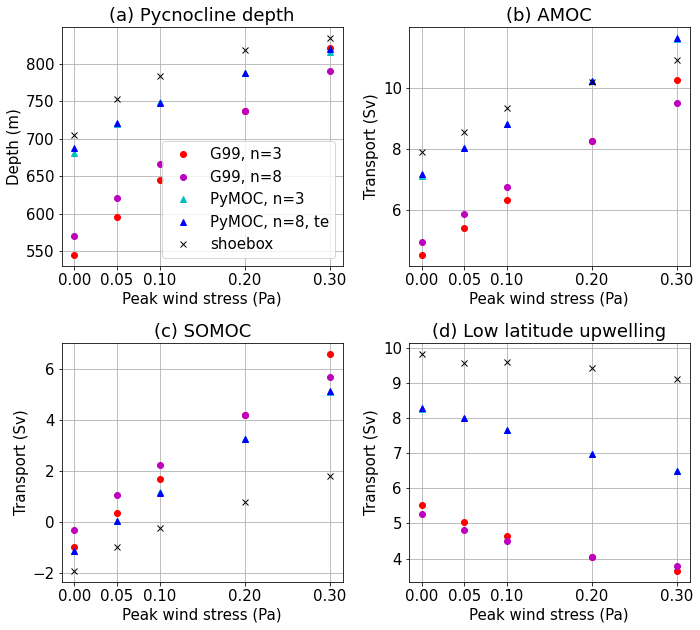

In [22]:
# Plot the 4 variables vs. wind
# Ts_sb is evaluated at 40S; sb D is averaged b/t 40S - 40N
wind = [0, 0.05, 0.1, 0.2, 0.3]
plt.figure(figsize=[10, 9])

###################### pycnoline depth #################
Dsb2 = [705.4390, 752.5691, 784.1237, 817.9258, 834.2753]
DPyMOCn3 = np.array([Dtp0n3t[-1], Dtp05n3t[-1], Dtp1n3t[-1], Dtp2n3t[-1], Dtp3n3t[-1]])
# DPyMOCn8 = np.array([Dtp0n8t[-1], Dtp05n8t[-1], Dtp1n8t[-1], Dtp2n8t[-1], Dtp3n8t[-1]])
DPyMOCn8te = np.array([Dtp0n8tet[-1], Dtp05n8tet[-1], Dtp1n8tet[-1], Dtp2n8tet[-1], Dtp3n8tet[-1]])

plt.subplot(2, 2, 1)
plt.plot(wind, D_equi[2, :], 'ro', label='G99, n=3')
plt.plot(wind, D_equi[3, :], 'mo', label='G99, n=8')
plt.plot(wind, DPyMOCn3, 'c^', label='PyMOC, n=3')
plt.plot(wind, DPyMOCn8te, 'b^', label='PyMOC, n=8, te')

plt.plot(wind, Dsb2, 'kx', label='shoebox')

plt.grid()
plt.xticks(wind)
plt.legend()
plt.xlabel('Peak wind stress (Pa)')
plt.ylabel('Depth (m)')
plt.title('(a) Pycnocline depth')

#################### AMOC: max at 45 N; layer 12 #####################
lat = N45
Tnsb = np.array([sbsftp0[lat, 12], sbsftp05[lat, 12], sbsftp1[lat, 12], 
                sbsftp2[lat, 12], sbsftp3[lat, 12]])
TnPyMOCn3 = np.array([AMOCtp0n3zt[-1, -5], AMOCtp05n3zt[-1, -5], AMOCtp1n3zt[-1, -5], 
                   AMOCtp2n3zt[-1, -5], AMOCtp3n3zt[-1, -5]])
# TnPyMOCn8 = np.array([AMOCtp0n8zt[-1, -5], AMOCtp05n8zt[-1, -5], AMOCtp1n8zt[-1, -5], 
#                    AMOCtp2n8zt[-1, -5], AMOCtp3n8zt[-1, -5]])
TnPyMOCn8te = np.array([AMOCtp0n8tezt[-1, -5], AMOCtp05n8tezt[-1, -5], 
                        AMOCtp1n8tezt[-1, -5], AMOCtp2n8tezt[-1, -5], 
                        AMOCtp3n8tezt[-1, -5]])
plt.subplot(2, 2, 2)
plt.plot(wind, T_N[2, :], 'ro', label='G99, n=3')
plt.plot(wind, T_N[3, :], 'mo', label='G99, n=8')
plt.plot(wind, TnPyMOCn3, 'c^', label='PyMOC, n=3')
plt.plot(wind, TnPyMOCn8te, 'b^', label='PyMOC, n=8, te')
plt.plot(wind, Tnsb, 'kx', label='shoebox')

plt.xticks(wind)
plt.grid()
plt.xlabel('Peak wind stress (Pa)')
plt.ylabel('Transport (Sv)')
plt.title('(b) AMOC')

##################### SOMOC; sb: sf(40S, layer 12) ##################
TsPyMOCn3 = np.array([SOtp0n3z[-5], SOtp05n3z[-5], SOtp1n3z[-5], SOtp2n3z[-5], 
                    SOtp3n3z[-5]])
# TsPyMOCn8 = np.array([SOtp0n8z[-5], SOtp05n8z[-5], SOtp1n8z[-5], SOtp2n8z[-5], 
#                     SOtp3n8z[-5]])
TsPyMOCn8te = np.array([SOtp0n8tez[-5], SOtp05n8tez[-5], SOtp1n8tez[-5], 
                        SOtp2n8tez[-5], SOtp3n8tez[-5]])
Twsb = np.array([0., 1.6717, 3.3434, 6.6868, 10.0303])
lat = S40
Tssb = np.array([sbsftp0[lat, 12], sbsftp05[lat, 12], sbsftp1[lat, 12], 
                sbsftp2[lat, 12], sbsftp3[lat, 12]])

plt.subplot(2, 2, 3)
plt.plot(wind, Twsb - T_eddy[2, :], 'ro', label='G99, n=3')
plt.plot(wind, Twsb - T_eddy[3, :], 'mo', label='G99, n=8')
plt.plot(wind, TsPyMOCn3, 'c^', label='PyMOC, n=3')
plt.plot(wind, TsPyMOCn8te, 'b^', label='PyMOC, n=8, te')
plt.plot(wind, Tssb, 'kx', label='shoebox')

plt.grid()
plt.xticks(wind)
# plt.legend()
plt.xlabel('Peak wind stress (Pa)')
plt.ylabel('Transport (Sv)')
plt.title('(c) SOMOC')


#################### basin upwelling ####################
TuPyMOCn3 = TnPyMOCn3 - TsPyMOCn3
# TuPyMOCn8 = TnPyMOCn8 - TsPyMOCn8
TuPyMOCn8te = TnPyMOCn8te - TsPyMOCn8te
Tusb = Tnsb - Tssb

plt.subplot(2, 2, 4)
plt.plot(wind, T_U[2, :], 'ro', label='G99, n=3')
plt.plot(wind, T_U[3, :], 'mo', label='G99, n=8')
plt.plot(wind, TuPyMOCn3, 'c^', label='PyMOC, n=3')
plt.plot(wind, TuPyMOCn8te, 'b^', label='PyMOC, n=8, te')
plt.plot(wind, Tusb, 'kx', label='shoebox')
plt.grid()
plt.xticks(wind)
# plt.legend()
plt.xlabel('Peak wind stress (Pa)')
plt.ylabel('Transport (Sv)')
plt.title('(d) Low latitude upwelling')

plt.rcParams.update({'font.size': 15})
plt.tight_layout()

# plt.savefig('pics/paper_pics/Equi_comp.pdf')

## Diffusivity comparison

Text(0.5, 1.0, '$\\kappa_{GM}$ from shoebox, pymoc, & G99')

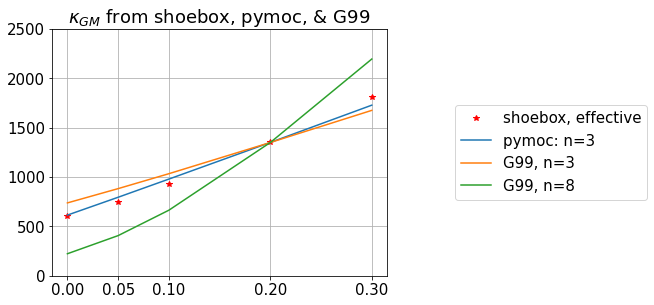

In [23]:
# re-calculate KGM from shoebox vs. pymoc
KGMpymocn3 = K0*DPyMOCn3/D0 * (1 + K1*np.array(wind)/wind[3])
# KGMpymocn8 = K0*(DPyMOCn8/D0)**7 * (1 + K1*np.array(wind)/wind[3])

KGMG99n3 = K0_G99*(D_equi[2, :]/D0_G99)**2 # G99, n = 3
KGMG99n8 = K0_G99*(D_equi[3, :]/D0_G99)**7 # G99, n = 8

plt.figure(figsize=[6, 10])
plt.subplot(2, 1, 1)
plt.plot(wind, sbKGM_40S, 'r*', label='shoebox, effective')
plt.plot(wind, KGMpymocn3, label='pymoc: n=3')
# plt.plot(wind, KGMpymocn8, label='pymoc: n=8')
plt.plot(wind, KGMG99n3, label='G99, n=3')
plt.plot(wind, KGMG99n8, label='G99, n=8')

plt.ylim([0, 2500])
plt.xticks(wind)
plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
plt.grid()
plt.title(r'$\kappa_{GM}$ from shoebox, pymoc, & G99')

# Time-dependent response analysis

Different from the GCM, the AMOC max always occurs at the same depth, not buoyancy/isopycnal, level. This makes tracking the depth evolution of a certain isopycnal less meaningful. We can of course track the buoyancy evolution at a fixed depth, but it only makes sense to study its timescale, and cannot be shown in the 4-panel equilibrium response figure. 

## Pycnocline depth timeseries

In [30]:
# Read in shoebox data & fit exponential curve
# shoebox data
TDtp0 = sio.loadmat('result/TD_sb2GnMap12tp0KHTH100.mat') 
TDtp05 = sio.loadmat('result/TD_sb2GnMap12tp05KHTH100.mat') 
TDtp1 = sio.loadmat('result/TD_sb2GnMap12tp1KHTH100.mat') 
TDtp3 = sio.loadmat('result/TD_sb2GnMap12tp3KHTH100r.mat') 

# shoebox D: 40S - 40N
Dsb2 = [705.4390, 752.5691, 784.1237, 817.9258, 834.2753]

# fit exp curves to D timeseries: a*exp(-x/t)
x = np.linspace(0, len(Dtp3n3t)-1, num=len(Dtp3n3t))
def exp_fit(x, a, b, t):
    return a + b*np.exp(-x/t)
p0 = [1, 1, 500] # initial guess for a & t
bounds = (-1000, 2000) # parameter bounds
par_Dtp3, ttt = curve_fit(exp_fit, x, Dtp3n3t-Dtp2n3t[-1], p0=p0, bounds=bounds)
par_Dtp3sb, ttt = curve_fit(exp_fit, x[1:], -TDtp3['D'][2]-Dsb2[3], p0=p0, bounds=bounds)
par_Dtp1, ttt = curve_fit(exp_fit, x, Dtp1n3t-Dtp2n3t[-1], p0=p0, bounds=bounds)
par_Dtp1sb, ttt = curve_fit(exp_fit, x[1:], -TDtp1['D'][2]-Dsb2[3], p0=p0, bounds=bounds)
par_Dtp05, ttt = curve_fit(exp_fit, x, Dtp05n3t-Dtp2n3t[-1], p0=p0, bounds=bounds)
par_Dtp05sb, ttt = curve_fit(exp_fit, x[1:], -TDtp05['D'][2][:3000]-Dsb2[3], p0=p0, bounds=bounds)
par_Dtp0, ttt = curve_fit(exp_fit, x, Dtp0n3t-Dtp2n3t[-1], p0=p0, bounds=bounds)
par_Dtp0sb, ttt = curve_fit(exp_fit, x[1:], -TDtp0['D'][2]-Dsb2[3], p0=p0, bounds=bounds)

par_Dtp3sbs, ttt = curve_fit(exp_fit, x[1:], -TDtp3['D'][0]-Dsb2[3], p0=p0, bounds=bounds)

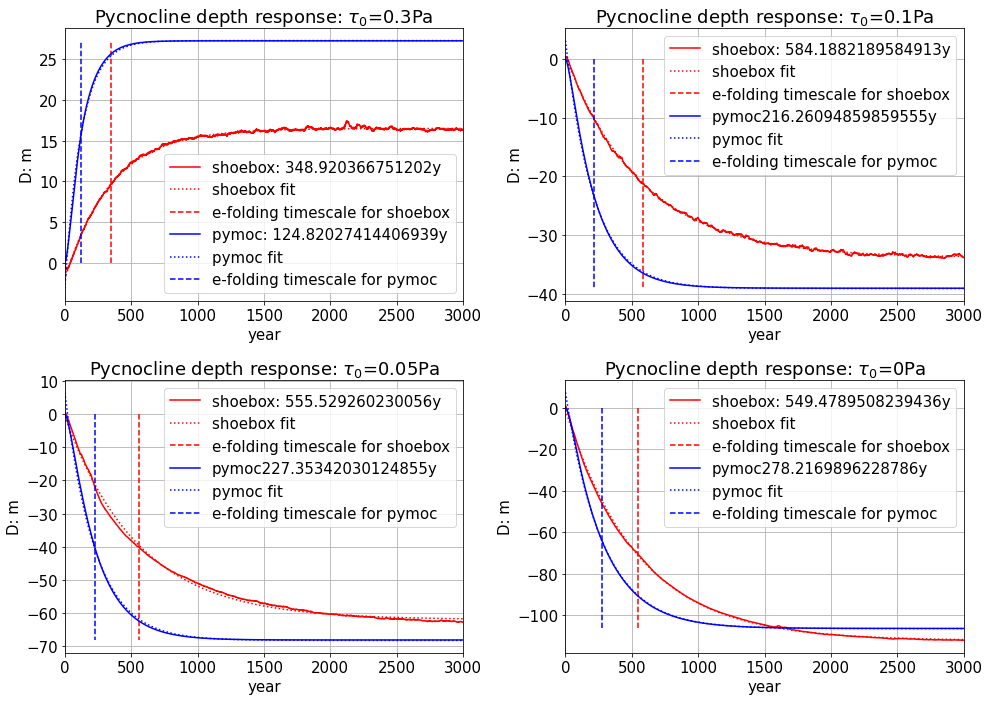

In [33]:
# plot: timeseries under all 4 winds
plt.figure(figsize=[14, 10])
xlim=[0, 3000]

plt.subplot(2, 2, 1)
plt.plot(-TDtp3['D'][2]-Dsb2[3], 'r', label='shoebox: '+str(par_Dtp3sb[2])+'y')
plt.plot(x, par_Dtp3sb[0]+par_Dtp3sb[1]*np.exp(-x/par_Dtp3sb[2]), 'r:', label='shoebox fit')
plt.plot([par_Dtp3sb[2], par_Dtp3sb[2]], [0, Dtp3n3t[-1]-Dtp2n3t[-1]], 'r--', label='e-folding timescale for shoebox')
plt.plot(Dtp3n3t-Dtp2n3t[-1], 'b', label='pymoc: '+str(par_Dtp3[2])+'y')
plt.plot(x, par_Dtp3[0]+par_Dtp3[1]*np.exp(-x/par_Dtp3[2]), 'b:', label='pymoc fit')
plt.plot([par_Dtp3[2], par_Dtp3[2]], [0, Dtp3n3t[-1]-Dtp2n3t[-1]], 'b--', label='e-folding timescale for pymoc')

plt.legend()
plt.grid()
plt.xlim(xlim)
plt.xlabel('year')
plt.ylabel('D: m')
plt.title(r'Pycnocline depth response: $\tau_0$=0.3Pa')

plt.subplot(2, 2, 2)
plt.plot(-TDtp1['D'][2]-Dsb2[3], 'r', label='shoebox: '+str(par_Dtp1sb[2])+'y')
plt.plot(x, par_Dtp1sb[0]+par_Dtp1sb[1]*np.exp(-x/par_Dtp1sb[2]), 'r:', label='shoebox fit')
plt.plot([par_Dtp1sb[2], par_Dtp1sb[2]], [0, Dtp1n3t[-1]-Dtp2n3t[-1]], 'r--', label='e-folding timescale for shoebox')
plt.plot(Dtp1n3t-Dtp2n3t[-1], 'b', label='pymoc'+str(par_Dtp1[2])+'y')
plt.plot(x, par_Dtp1[0]+par_Dtp1[1]*np.exp(-x/par_Dtp1[2]), 'b:', label='pymoc fit')
plt.plot([par_Dtp1[2], par_Dtp1[2]], [0, Dtp1n3t[-1]-Dtp2n3t[-1]], 'b--', label='e-folding timescale for pymoc')

plt.legend()
plt.grid()
plt.xlim(xlim)
plt.xlabel('year')
plt.ylabel('D: m')
plt.title(r'Pycnocline depth response: $\tau_0$=0.1Pa')

plt.subplot(2, 2, 3)
plt.plot(-TDtp05['D'][2]-Dsb2[3], 'r', label='shoebox: '+str(par_Dtp05sb[2])+'y')
plt.plot(x, par_Dtp05sb[0]+par_Dtp05sb[1]*np.exp(-x/par_Dtp05sb[2]), 'r:', label='shoebox fit')
plt.plot([par_Dtp05sb[2], par_Dtp05sb[2]], [0, Dtp05n3t[-1]-Dtp2n3t[-1]], 'r--', label='e-folding timescale for shoebox')
plt.plot(Dtp05n3t-Dtp2n3t[-1], 'b', label='pymoc'+str(par_Dtp05[2])+'y')
plt.plot(x, par_Dtp05[0]+par_Dtp05[1]*np.exp(-x/par_Dtp05[2]), 'b:', label='pymoc fit')
plt.plot([par_Dtp05[2], par_Dtp05[2]], [0, Dtp05n3t[-1]-Dtp2n3t[-1]], 'b--', label='e-folding timescale for pymoc')

plt.legend()
plt.grid()
plt.xlim(xlim)
plt.xlabel('year')
plt.ylabel('D: m')
plt.title(r'Pycnocline depth response: $\tau_0$=0.05Pa')

plt.subplot(2, 2, 4)
plt.plot(-TDtp0['D'][2]-Dsb2[3], 'r', label='shoebox: '+str(par_Dtp0sb[2])+'y')
plt.plot(x, par_Dtp0sb[0]+par_Dtp0sb[1]*np.exp(-x/par_Dtp0sb[2]), 'r:', label='shoebox fit')
plt.plot([par_Dtp0sb[2], par_Dtp0sb[2]], [0, Dtp0n3t[-1]-Dtp2n3t[-1]], 'r--', label='e-folding timescale for shoebox')
plt.plot(Dtp0n3t-Dtp2n3t[-1], 'b', label='pymoc'+str(par_Dtp0[2])+'y')
plt.plot(x, par_Dtp0[0]+par_Dtp0[1]*np.exp(-x/par_Dtp0[2]), 'b:', label='pymoc fit')
plt.plot([par_Dtp0[2], par_Dtp0[2]], [0, Dtp0n3t[-1]-Dtp2n3t[-1]], 'b--', label='e-folding timescale for pymoc')

plt.legend()
plt.grid()
plt.xlim(xlim)
plt.xlabel('year')
plt.ylabel('D: m')
plt.title(r'Pycnocline depth response: $\tau_0$=0Pa')

plt.tight_layout()

# plt.savefig('pics/TD_Kst_Ktr_bsp019_n2.pdf')

Even longer timescale than KGM only scheme, with n=2

## Anomalous interface height Hovmoeller diagram

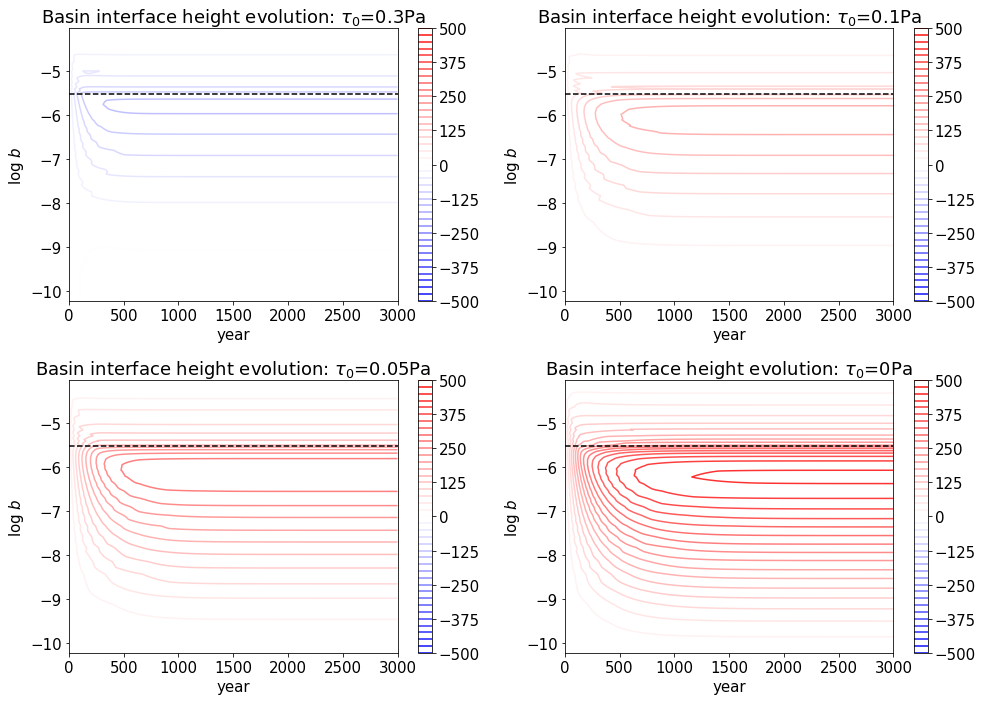

In [34]:
# collapsing purpose
plt.figure(figsize=[14, 10])
levels=np.arange(-500., 525., 25.)

plt.subplot(2,2,1)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(zb_basintp3n3t-zb_basintp2n3), \
            levels=levels, cmap=plt.cm.bwr)
plt.plot([0, 3000], [np.log(bs_north+bcoord[1]), np.log(bs_north+bcoord[1])],\
        'k--')
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'Basin interface height evolution: $\tau_0$=0.3Pa')

plt.subplot(2,2,2)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(zb_basintp1n3t-zb_basintp2n3), \
            levels=levels, cmap=plt.cm.bwr)
plt.plot([0, 3000], [np.log(bs_north+bcoord[1]), np.log(bs_north+bcoord[1])],\
        'k--')
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'Basin interface height evolution: $\tau_0$=0.1Pa')

plt.subplot(2,2,3)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(zb_basintp05n3t-zb_basintp2n3), \
            levels=levels, cmap=plt.cm.bwr)
plt.plot([0, 3000], [np.log(bs_north+bcoord[1]), np.log(bs_north+bcoord[1])],\
        'k--')
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'Basin interface height evolution: $\tau_0$=0.05Pa')

plt.subplot(2,2,4)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(zb_basintp0n3t-zb_basintp2n3), \
            levels=levels, cmap=plt.cm.bwr)
plt.plot([0, 3000], [np.log(bs_north+bcoord[1]), np.log(bs_north+bcoord[1])],\
        'k--')
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'Basin interface height evolution: $\tau_0$=0Pa')

plt.tight_layout()

# plt.savefig('pics/Hov_eta_basin_Kst_Ktr_bsp019_n2.pdf')

## Anomalous SOMOC Hovmoeller

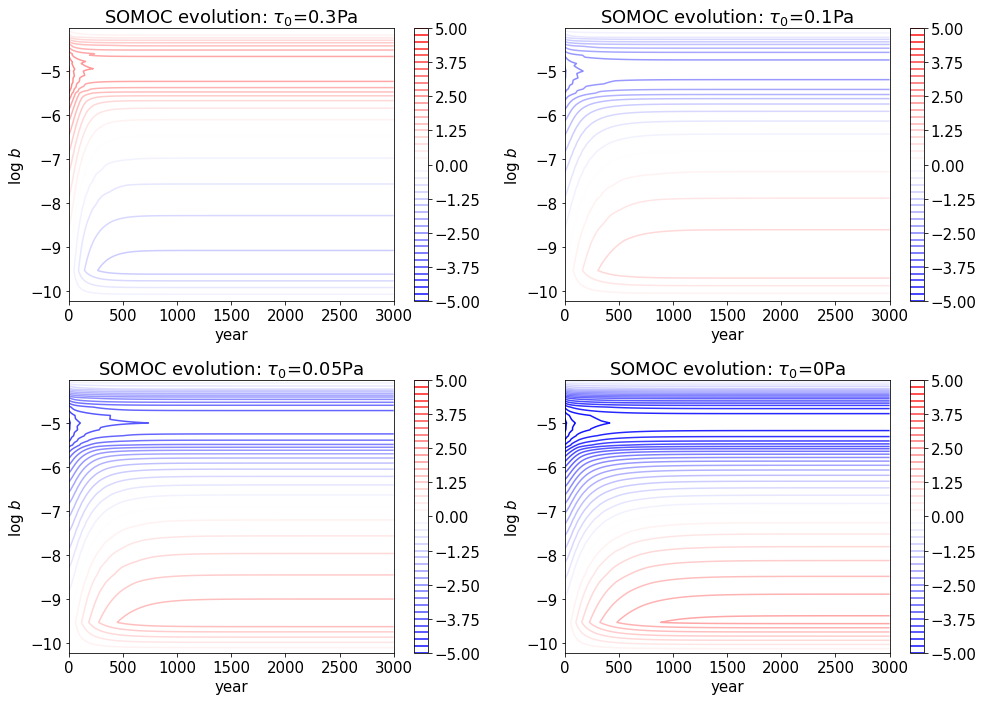

In [35]:
# collapsing purpose
plt.figure(figsize=[14, 10])
levels=np.arange(-5., 5.25, .25)

plt.subplot(2,2,1)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(SOtp3n3bt-SOtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
# plt.ylim([np.log(bcoord[105]+bcoord[1]), np.log(bcoord[-1]+bcoord[1])])
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'SOMOC evolution: $\tau_0$=0.3Pa')

plt.subplot(2,2,2)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(SOtp1n3bt-SOtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'SOMOC evolution: $\tau_0$=0.1Pa')

plt.subplot(2,2,3)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(SOtp05n3bt-SOtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'SOMOC evolution: $\tau_0$=0.05Pa')

plt.subplot(2,2,4)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(SOtp0n3bt-SOtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'SOMOC evolution: $\tau_0$=0Pa')

plt.tight_layout()
# plt.savefig('pics/Hov_SOMOC_b_Kst_Ktr_bsp019_n2.pdf')

Abyssal ocean response much larger than shoebox 

## SOMOC peak value timeseries

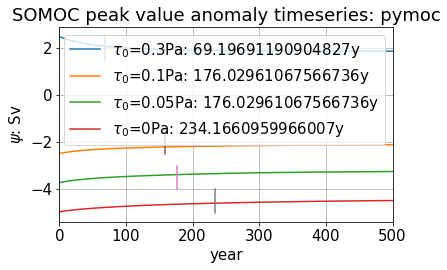

In [38]:
# Timeseries of peak value of SO
par_SOtp3, ttt = curve_fit(exp_fit, x, SOtp3n3zt[:, -5]- SOtp2n3z[-5], \
                           p0=p0, bounds=bounds)
par_SOtp1, ttt = curve_fit(exp_fit, x, SOtp1n3zt[:, -5]- SOtp2n3z[-5], \
                           p0=p0, bounds=bounds)
par_SOtp05, ttt = curve_fit(exp_fit, x, SOtp05n3zt[:, -5]- SOtp2n3z[-5], \
                           p0=p0, bounds=bounds)
par_SOtp0, ttt = curve_fit(exp_fit, x, SOtp0n3zt[:, -5]- SOtp2n3z[-5], \
                           p0=p0, bounds=bounds)

plt.plot(SOtp3n3zt[:, -5]- SOtp2n3z[-5], label=r'$\tau_0$=0.3Pa: '+str(par_SOtp3[2])+'y')
plt.plot(SOtp1n3zt[:, -5]- SOtp2n3z[-5], label=r'$\tau_0$=0.1Pa: '+str(par_SOtp05[2])+'y')
plt.plot(SOtp05n3zt[:, -5]- SOtp2n3z[-5], label=r'$\tau_0$=0.05Pa: '+str(par_SOtp05[2])+'y')
plt.plot(SOtp0n3zt[:, -5]- SOtp2n3z[-5], label=r'$\tau_0$=0Pa: '+str(par_SOtp0[2])+'y')

plt.plot([par_SOtp3[2], par_SOtp3[2]], [1.5, 2.5])
plt.plot([par_SOtp1[2], par_SOtp1[2]], [-2.5, -1.5])
plt.plot([par_SOtp05[2], par_SOtp05[2]], [-4, -3])
plt.plot([par_SOtp0[2], par_SOtp0[2]], [-5, -4])

# plt.plot(x, par_SOtp0[0]+par_SOtp0[1]*np.exp(-x/par_SOtp0[2]), ':')

plt.xlim([0, 500])
plt.legend()
plt.grid()
plt.xlabel('year')
plt.ylabel(r'$\psi$: Sv')
plt.title('SOMOC peak value anomaly timeseries: pymoc')

plt.tight_layout()
# plt.savefig('pics/TSO_peak_z_Kst_Ktr_bsp019_n2.pdf')

## AMOC Hovmoeller

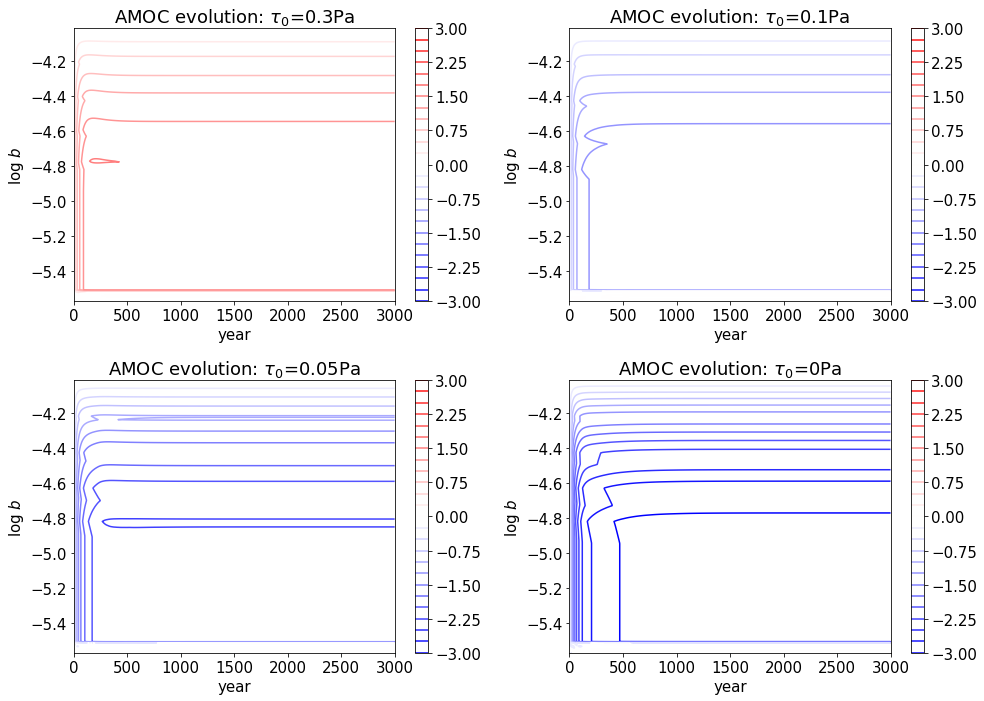

In [39]:
# plot
plt.figure(figsize=[14, 10])
levels=np.arange(-3., 3.25, .25)

plt.subplot(2,2,1)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(AMOCtp3n3bt-AMOCtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.ylim([np.log(bcoord[105]+bcoord[1]), np.log(bcoord[-1]+bcoord[1])])
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'AMOC evolution: $\tau_0$=0.3Pa')

plt.subplot(2,2,2)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(AMOCtp1n3bt-AMOCtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.ylim([np.log(bcoord[105]+bcoord[1]), np.log(bcoord[-1]+bcoord[1])])
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'AMOC evolution: $\tau_0$=0.1Pa')

plt.subplot(2,2,3)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(AMOCtp05n3bt-AMOCtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.ylim([np.log(bcoord[105]+bcoord[1]), np.log(bcoord[-1]+bcoord[1])])
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'AMOC evolution: $\tau_0$=0.05Pa')

plt.subplot(2,2,4)
plt.contour(x, np.log(bcoord+bcoord[1]), np.transpose(AMOCtp0n3bt-AMOCtp2n3b), \
            levels=levels, cmap=plt.cm.bwr)
plt.colorbar()
plt.ylim([np.log(bcoord[105]+bcoord[1]), np.log(bcoord[-1]+bcoord[1])])
plt.xlabel('year')
plt.ylabel(r'$\log\ b$')
plt.title(r'AMOC evolution: $\tau_0$=0Pa')

plt.tight_layout()

# plt.savefig('pics/Hov_AMOCMOC_b_Kst_Ktr_bsp019_n2.pdf')

The overshooting is captured (and more significant), but the recovery timescale is longer than shoebox

## AMOC peak value timeseries

Text(0.5, 1.0, 'AMOC peak value anomaly timeseries: pymoc')

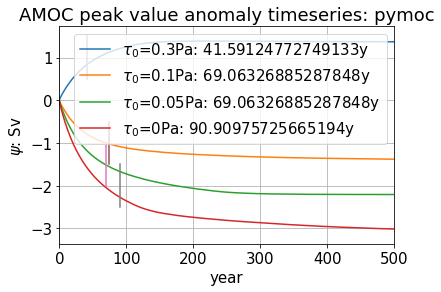

In [40]:
# Timeseries of peak value of AMOC
par_AMOCtp3, ttt = curve_fit(exp_fit, x, AMOCtp3n3zt[:, -5]- AMOCtp2n3zt[-1, -5], \
                           p0=p0, bounds=bounds)
par_AMOCtp1, ttt = curve_fit(exp_fit, x, AMOCtp1n3zt[:, -5]- AMOCtp2n3zt[-1, -5], \
                           p0=p0, bounds=bounds)
par_AMOCtp05, ttt = curve_fit(exp_fit, x, AMOCtp05n3zt[:, -5]- AMOCtp2n3zt[-1, -5], \
                           p0=p0, bounds=bounds)
par_AMOCtp0, ttt = curve_fit(exp_fit, x, AMOCtp0n3zt[:, -5]- AMOCtp2n3zt[-1, -5], \
                           p0=p0, bounds=bounds)

plt.plot(AMOCtp3n3zt[:, -5]- AMOCtp2n3zt[-1, -5], label=r'$\tau_0$=0.3Pa: '+str(par_AMOCtp3[2])+'y')
plt.plot(AMOCtp1n3zt[:, -5]- AMOCtp2n3zt[-1, -5], label=r'$\tau_0$=0.1Pa: '+str(par_AMOCtp05[2])+'y')
plt.plot(AMOCtp05n3zt[:, -5]- AMOCtp2n3zt[-1, -5], label=r'$\tau_0$=0.05Pa: '+str(par_AMOCtp05[2])+'y')
plt.plot(AMOCtp0n3zt[:, -5]- AMOCtp2n3zt[-1, -5], label=r'$\tau_0$=0Pa: '+str(par_AMOCtp0[2])+'y')

plt.plot([par_AMOCtp3[2], par_AMOCtp3[2]], [.5, 1.5])
plt.plot([par_AMOCtp1[2], par_AMOCtp1[2]], [-1.5, -.5])
plt.plot([par_AMOCtp05[2], par_AMOCtp05[2]], [-2, -1])
plt.plot([par_AMOCtp0[2], par_AMOCtp0[2]], [-2.5, -1.5])

# plt.plot(x, par_AMOCtp0[0]+par_AMOCtp0[1]*np.exp(-x/par_AMOCtp0[2]), ':')

plt.xlim([0, 500])
plt.legend()
plt.grid()
plt.xlabel('year')
plt.ylabel(r'$\psi$: Sv')
plt.title('AMOC peak value anomaly timeseries: pymoc')

# plt.savefig('pics/TAMOC_peak_z_Kst_Ktr_bsp019_n2.pdf')

## Scattered AMOC vs. D: Fig. 4.19

In [41]:
# Compute decadal mean of pycnocline depth & AMOC from pymoc
Dtp3tmean = [np.mean(Dtp3n3t[i:i+10]) for i in range(0, len(Dtp3n3t), 10)]
Dtp1tmean = [np.mean(Dtp1n3t[i:i+10]) for i in range(0, len(Dtp1n3t), 10)]
Dtp05tmean = [np.mean(Dtp05n3t[i:i+10]) for i in range(0, len(Dtp05n3t), 10)]
Dtp0tmean = [np.mean(Dtp0n3t[i:i+10]) for i in range(0, len(Dtp0n3t), 10)]

AMOCtp3ztmean = [np.mean(AMOCtp3n3zt[i:i+10, -5]) for i in range(0, len(Dtp3n3t), 10)]
AMOCtp1ztmean = [np.mean(AMOCtp1n3zt[i:i+10, -5]) for i in range(0, len(Dtp3n3t), 10)]
AMOCtp05ztmean = [np.mean(AMOCtp05n3zt[i:i+10, -5]) for i in range(0, len(Dtp3n3t), 10)]
AMOCtp0ztmean = [np.mean(AMOCtp0n3zt[i:i+10, -5]) for i in range(0, len(Dtp3n3t), 10)]

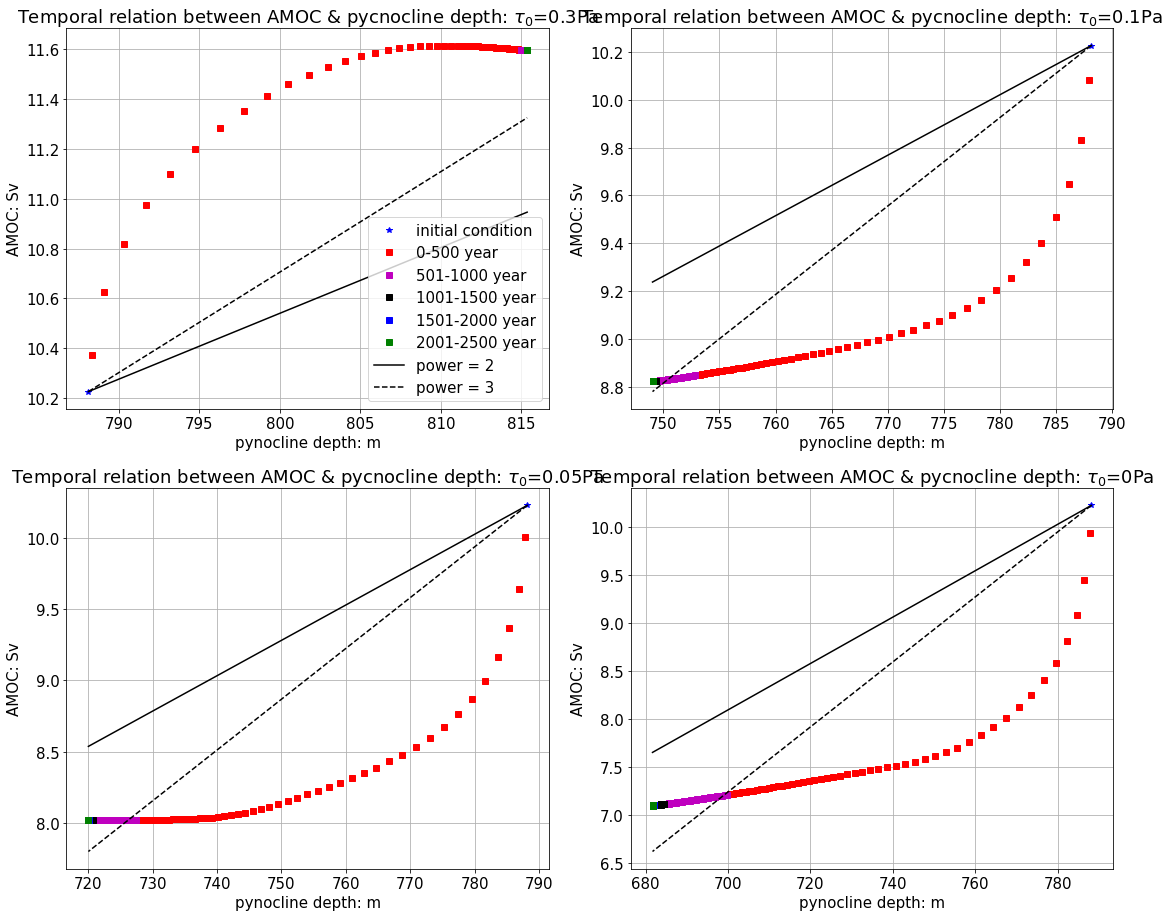

In [45]:
# plot

plt.figure(figsize=[16, 13])

plt.subplot(2,2,1)
plt.plot(Dtp2n3t[-1], AMOCtp2n3zt[-1, -5], 'b*', label='initial condition')
plt.plot(Dtp3tmean[:50], AMOCtp3ztmean[:50], 'rs', label='0-500 year')
plt.plot(Dtp3tmean[50:100], AMOCtp3ztmean[50:100], 'ms', label='501-1000 year')
plt.plot(Dtp3tmean[100:150], AMOCtp3ztmean[100:150], 'ks', label='1001-1500 year')
plt.plot(Dtp3tmean[150:200], AMOCtp3ztmean[150:200], 'bs', label='1501-2000 year')
plt.plot(Dtp3tmean[200:250], AMOCtp3ztmean[200:250], 'gs', label='2001-2500 year')
r2 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**2
plt.plot([Dtp2n3t[-1], Dtp3tmean[-1]], [r2*Dtp2n3t[-1]**2, r2*Dtp3tmean[-1]**2], 'k', label='power = 2')
r3 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**3
plt.plot([Dtp2n3t[-1], Dtp3tmean[-1]], [r3*Dtp2n3t[-1]**3, r3*Dtp3tmean[-1]**3], 'k--', label='power = 3')
plt.legend()
plt.grid()
plt.xlabel('pynocline depth: m')
plt.ylabel('AMOC: Sv')
plt.title(r'Temporal relation between AMOC & pycnocline depth: $\tau_0$=0.3Pa')

plt.subplot(2,2,2)
plt.plot(Dtp2n3t[-1], AMOCtp2n3zt[-1, -5], 'b*', label='initial condition')
plt.plot(Dtp1tmean[:50], AMOCtp1ztmean[:50], 'rs', label='0-500 year')
plt.plot(Dtp1tmean[50:100], AMOCtp1ztmean[50:100], 'ms', label='501-1000 year')
plt.plot(Dtp1tmean[100:150], AMOCtp1ztmean[100:150], 'ks', label='1001-1500 year')
plt.plot(Dtp1tmean[150:200], AMOCtp1ztmean[150:200], 'bs', label='1501-2000 year')
plt.plot(Dtp1tmean[200:250], AMOCtp1ztmean[200:250], 'gs', label='2001-2500 year')
r2 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**2
plt.plot([Dtp2n3t[-1], Dtp1tmean[-1]], [r2*Dtp2n3t[-1]**2, r2*Dtp1tmean[-1]**2], 'k', label='power = 2')
r3 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**3
plt.plot([Dtp2n3t[-1], Dtp1tmean[-1]], [r3*Dtp2n3t[-1]**3, r3*Dtp1tmean[-1]**3], 'k--', label='power = 3')
# plt.legend()
plt.grid()
plt.xlabel('pynocline depth: m')
plt.ylabel('AMOC: Sv')
plt.title(r'Temporal relation between AMOC & pycnocline depth: $\tau_0$=0.1Pa')

plt.subplot(2,2,3)
plt.plot(Dtp2n3t[-1], AMOCtp2n3zt[-1, -5], 'b*', label='initial condition')
plt.plot(Dtp05tmean[:50], AMOCtp05ztmean[:50], 'rs', label='0-500 year')
plt.plot(Dtp05tmean[50:100], AMOCtp05ztmean[50:100], 'ms', label='501-1000 year')
plt.plot(Dtp05tmean[100:150], AMOCtp05ztmean[100:150], 'ks', label='1001-1500 year')
plt.plot(Dtp05tmean[150:200], AMOCtp05ztmean[150:200], 'bs', label='1501-2000 year')
plt.plot(Dtp05tmean[200:250], AMOCtp05ztmean[200:250], 'gs', label='2001-2500 year')
r2 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**2
plt.plot([Dtp2n3t[-1], Dtp05tmean[-1]], [r2*Dtp2n3t[-1]**2, r2*Dtp05tmean[-1]**2], 'k', label='power = 2')
r3 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**3
plt.plot([Dtp2n3t[-1], Dtp05tmean[-1]], [r3*Dtp2n3t[-1]**3, r3*Dtp05tmean[-1]**3], 'k--', label='power = 3')
# plt.legend()
plt.grid()
plt.xlabel('pynocline depth: m')
plt.ylabel('AMOC: Sv')
plt.title(r'Temporal relation between AMOC & pycnocline depth: $\tau_0$=0.05Pa')

plt.subplot(2,2,4)
plt.plot(Dtp2n3t[-1], AMOCtp2n3zt[-1, -5], 'b*', label='initial condition')
plt.plot(Dtp0tmean[:50], AMOCtp0ztmean[:50], 'rs', label='0-500 year')
plt.plot(Dtp0tmean[50:100], AMOCtp0ztmean[50:100], 'ms', label='501-1000 year')
plt.plot(Dtp0tmean[100:150], AMOCtp0ztmean[100:150], 'ks', label='1001-1500 year')
plt.plot(Dtp0tmean[150:200], AMOCtp0ztmean[150:200], 'bs', label='1501-2000 year')
plt.plot(Dtp0tmean[200:250], AMOCtp0ztmean[200:250], 'gs', label='2001-2500 year')
r2 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**2
plt.plot([Dtp2n3t[-1], Dtp0tmean[-1]], [r2*Dtp2n3t[-1]**2, r2*Dtp0tmean[-1]**2], 'k', label='power = 2')
r3 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**3
plt.plot([Dtp2n3t[-1], Dtp0tmean[-1]], [r3*Dtp2n3t[-1]**3, r3*Dtp0tmean[-1]**3], 'k--', label='power = 3')
# plt.legend()
plt.grid()
plt.xlabel('pynocline depth: m')
plt.ylabel('AMOC: Sv')
plt.title(r'Temporal relation between AMOC & pycnocline depth: $\tau_0$=0Pa')

plt.tight_layout()
# plt.savefig('pics/plot_AMOC_D_Kst_Ktr_bsp019_n2.pdf')

Problem: now AMOC depends on D with a power of 3, not 2

## Scattered AMOC vs. D: both models

In [46]:
# Compute decadal mean of D & AMOC from shoebox & pymoc
Dtp3tmeansb = [np.mean(-TDtp3['D'][2, i:i+10]) 
               for i in range(0, len(TDtp3['D'][2,:]), 10)]
# Dtp3tmeansb = -Dtp3tmeansb
AMOCtp3tmeansb = sio.loadmat('result/TMOC_sb2GnMap12tp3KHTH100r.mat')['MOC10y'][2]
# MOC10yr structure: 4 * len(t), where 4 stands for the 4 locations

# PyMOC
Dtp3tmean = [np.mean(Dtp3n3t[i:i+10]) for i in range(0, len(Dtp3n3t), 10)]
AMOCtp3ztmean = [np.mean(AMOCtp3n3zt[i:i+10, -5]) for i in range(0, len(Dtp3n3t), 10)]


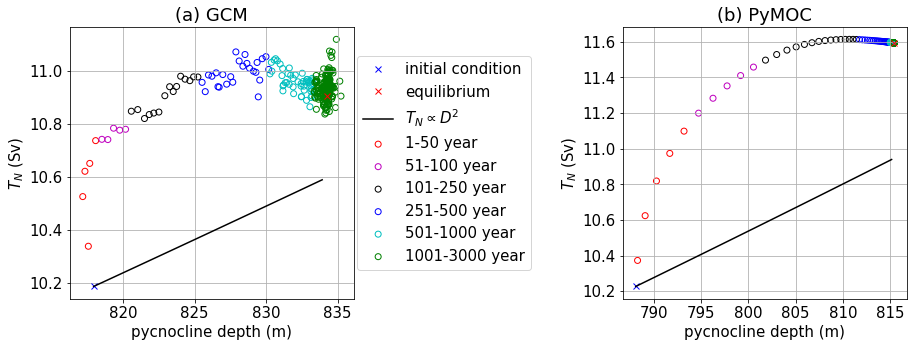

In [47]:
# pymoc & shoebox: 0.3 Pa only

fig = plt.figure(figsize=[15, 5])
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 0.6, 1])
latn = N45
# shoebox D
Dsb2 = [705.4390, 752.5691, 784.1237, 817.9258, 834.2753]

ax1 = fig.add_subplot(gs[0, 0])
# plt.subplot(1,2,1)
ax1.plot(Dsb2[3], sbsftp2[latn, 12], 'bx', label='initial condition')
ax1.scatter(Dtp3tmeansb[:5], AMOCtp3tmeansb[:5], facecolors="none", edgecolor="red", label='1-50 year')
ax1.scatter(Dtp3tmeansb[5:10], AMOCtp3tmeansb[5:10], facecolors="none", edgecolor="m", label='51-100 year')
ax1.scatter(Dtp3tmeansb[10:25], AMOCtp3tmeansb[10:25], facecolors="none", edgecolor="k", label='101-250 year')
ax1.scatter(Dtp3tmeansb[25:50], AMOCtp3tmeansb[25:50], facecolors="none", edgecolor="b", label='251-500 year')
ax1.scatter(Dtp3tmeansb[50:100], AMOCtp3tmeansb[50:100], facecolors="none", edgecolor="c", label='501-1000 year')
ax1.scatter(Dtp3tmeansb[100:300], AMOCtp3tmeansb[100:300], facecolors="none", edgecolor="g", label='1001-3000 year')
ax1.plot(Dsb2[4], AMOCtp3tmeansb[-1], 'rx', label='equilibrium')
# power 2 curve
Dx = np.arange(Dsb2[3], Dsb2[4], 1)
r2 = sbsftp2[latn, 12]/Dsb2[3]**2
ax1.plot(Dx, r2*Dx**2, 'k', label=r'$T_N\propto D^2$')

ax1.legend(loc='center right', bbox_to_anchor=(1.65, 0.5))
ax1.grid()
ax1.set_xlabel('pycnocline depth (m)')
ax1.set_ylabel(r'$T_N$ (Sv)')
ax1.set_title('(a) GCM')

# plt.subplot(1,2,2)
ax2 = fig.add_subplot(gs[0, 2])

ax2.plot(Dtp2n3t[-1], AMOCtp2n3zt[-1, -5], 'bx', label='initial condition')
ax2.scatter(Dtp3tmean[:5], AMOCtp3ztmean[:5], facecolors="none", edgecolor="red", label='1-50 year')
ax2.scatter(Dtp3tmean[5:10], AMOCtp3ztmean[5:10], facecolors="none", edgecolor="m", label='51-100 year')
ax2.scatter(Dtp3tmean[10:25], AMOCtp3ztmean[10:25], facecolors="none", edgecolor="k", label='101-250 year')
ax2.scatter(Dtp3tmean[25:50], AMOCtp3ztmean[25:50], facecolors="none", edgecolor="b", label='251-500 year')
ax2.scatter(Dtp3tmean[50:100], AMOCtp3ztmean[50:100], facecolors="none", edgecolor="c", label='501-1000 year')
ax2.scatter(Dtp3tmean[100:300], AMOCtp3ztmean[100:300], facecolors="none", edgecolor="g", label='1001-3000 year')
ax2.plot(Dtp3tmean[-1], AMOCtp3ztmean[-1], 'rx', label='equilibrium')

# power 2 curve
r2 = AMOCtp2n3zt[-1, -5]/Dtp2n3t[-1]**2
Dx = np.arange(Dtp2n3t[-1], Dtp3tmean[-1], 1)
ax2.plot(Dx, r2*Dx**2, 'k', label=r'$T_N\propto D^2$')

ax2.grid()
ax2.set_xlabel('pycnocline depth (m)')
ax2.set_ylabel(r'$T_N$ (Sv)')
ax2.set_title('(b) PyMOC')

plt.rcParams.update({'font.size': 15})
# plt.tight_layout()

# plt.savefig('pics/paper_pics/Scatter.pdf')